In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

In [2]:
#import os
from datetime import datetime
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import tensorboard
import torchvision

In [3]:
# Set seed for life
torch.manual_seed(42)
np.random.seed(42)

## Load data in class

In [18]:
#Make class from the dataset to use dataloader

from torch.utils.data import Dataset

class amino_acids(Dataset):
    res2num = {
        "ALA": 0, 
        "ASX": 1, 
        "CYS": 2, 
        "ASP": 3, 
        "GLU": 4, 
        "PHE": 5, 
        "GLY": 6, 
        "HIS": 7,
        "ILE": 8, 
        "LYS": 9, 
        "LEU": 10, 
        "MET": 11, 
        "ASN": 12, 
        "PRO": 13, 
        "GLN": 14,
        "ARG": 15, 
        "SER": 16, 
        "THR": 17, 
        "SEC": 18, 
        "VAL": 19, 
        "TRP": 20, 
        "XAA": 21,
        "TYR": 22, 
        "GLX": 23}
    
    old_names = ["ALA", "ASX", "CYS", "ASP", "GLU", "PHE", "GLY", "HIS", "ILE", "LYS", "LEU", "MET", "ASN", "PRO", "GLN", 
             "ARG", "SER", "THR", "SEC", "VAL", "TRP", "XAA","TYR", "GLX"]
    
    
    
    def __init__(self):#, split='train'):
        X = np.load('../data/dataset/train_feats.npy').astype(np.float32)
        X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
        y = np.load('../data/dataset/train_target.npy').astype(np.int64)
        
        X_old = X
        n_obs = y.shape[0]
        nonzero_index = (~np.all(y == 0, axis = 0)).nonzero()[0]
        names = []
        for i in nonzero_index:
            names.append(self.old_names[i])
    
        # Then remove zero columns from 'y'
        y = y[:,~np.all(y == 0, axis = 0)]

        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_old)
        # Added theta, so now 29 instead of 28 features per point
        X = X_scaled.reshape(n_obs, 50, 37)
        # Get integer values from one-hot encoding
        y_int = np.array([], dtype = np.int64)
        for i in y:
            y_int = np.concatenate((y_int, np.nonzero(i)[0]))

        # Save float and unique arrays of y_int
        y_float = y_int
        unique_y = np.unique(y_float)
        self.x_data = torch.from_numpy(X)
        self.y_data = torch.from_numpy(y_int)
        self.names = names
        self.y_int = y_int
        self.len = len(self.y_data)
        
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

dataset = amino_acids()

## Model

In [5]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Conv1d(input_dim, 50, 1, stride=1)
        self.drop_layer_1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(50, 10)
        self.drop_layer_2 = nn.Dropout(p=0.8)
        self.layer3 = nn.Linear(500, 100)
        self.layer4 = nn.Linear(100, 20)
        

        
    def forward(self, x):
        x = torch.transpose(x, 1,2)
        x = F.relu(self.layer1(x))
        x = self.drop_layer_1(x)
        x = F.relu(self.layer2(x))
        x = x.view(-1,10*50)
        x = self.drop_layer_2(x) # dropout module
        x = F.relu(self.layer3(x))
        x = F.sigmoid(self.layer4(x))
        
        return x

In [6]:
def reset_weights(m):
  '''
    Resetting the weights before each train-val run
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

## Train val and test epochs

In [7]:
def train(epoch):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 

  for data in tqdm(trainloader):
     
    inputs,labels=data[0],data[1]
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
        
  train_loss=running_loss/len(trainloader)
  train_accu=100.*correct/total
  
   
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,train_accu))#train_losses.append(train_loss)
  return train_loss, train_accu
  

In [8]:
def validate(epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for data in tqdm(valloader):
      inputs,labels=data[0],data[1]
       
      outputs=model(inputs)
 
      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
        
      
    
  val_loss=running_loss/len(valloader)
  val_accu=100.*correct/total

 
  print('val Loss: %.3f | Accuracy: %.3f'%(val_loss,val_accu)) 
  return val_loss, val_accu
  

## Balance dataset!!

In [9]:
class_sample_count = np.unique(dataset.y_int, return_counts=True)[1]
weight = 1. / class_sample_count
res_weight = Variable(torch.from_numpy(weight)).float()

In [10]:
# Define the K-fold Cross Validator
dataset   = amino_acids()
model     = Model(dataset.x_data.shape[2])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss(weight=res_weight)
k_folds = 4
epochs = 200
kfold = KFold(n_splits=k_folds, shuffle=True)

## Tensorboard

In [11]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard
%tensorboard --logdir=runs --port=5555

## Run run run

In [12]:
writer = SummaryWriter()
for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
    reset_weights(model)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    
    trainloader = DataLoader(dataset, batch_size = 1000, sampler=train_subsampler)
    valloader = DataLoader(dataset, batch_size = 200, sampler=val_subsampler)
    print('Current Fold is:', fold+1)
    for epoch in range(1,epochs+1): 
        train_loss, train_accu = train(epoch)
        
        val_loss, val_accu = validate(epoch)
        
        writer.add_scalars("Train/Val Loss" + str(fold+1), {'train loss':train_loss, 'val loss': val_loss}, epoch)
        writer.add_scalars("Train/Val Accuracy"+ str(fold+1), {'train accu':train_accu,'val accu':val_accu}, epoch)
        writer.flush()
    # Save model with name as datetime
    date = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")
    torch.save(model.state_dict(), f'../models/model_{fold}_{date}.pth')      
writer.close()

Reset trainable parameters of layer = Conv1d(37, 50, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = Linear(in_features=50, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Current Fold is: 1

Epoch : 1


  0%|                                                                                          | 0/28 [00:00<?, ?it/s]/work/lpdi/users/jansen/aa_iface_pred/ml-project-2-chopin-deux/amino-env/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 12.21it/s]


Train Loss: 2.996 | Accuracy: 7.232


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 171.06it/s]


val Loss: 2.994 | Accuracy: 8.631

Epoch : 2


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.59it/s]


Train Loss: 2.989 | Accuracy: 8.319


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 174.80it/s]


val Loss: 2.976 | Accuracy: 9.946

Epoch : 3


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.64it/s]


Train Loss: 2.963 | Accuracy: 10.422


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.24it/s]


val Loss: 2.951 | Accuracy: 11.261

Epoch : 4


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.55it/s]


Train Loss: 2.949 | Accuracy: 10.209


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.00it/s]


val Loss: 2.936 | Accuracy: 10.675

Epoch : 5


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.936 | Accuracy: 10.017


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.78it/s]


val Loss: 2.918 | Accuracy: 11.913

Epoch : 6


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.920 | Accuracy: 11.089


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.67it/s]


val Loss: 2.903 | Accuracy: 13.250

Epoch : 7


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.63it/s]


Train Loss: 2.907 | Accuracy: 11.660


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 163.72it/s]


val Loss: 2.886 | Accuracy: 14.145

Epoch : 8


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.21it/s]


Train Loss: 2.895 | Accuracy: 12.408


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.52it/s]


val Loss: 2.875 | Accuracy: 14.013

Epoch : 9


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.19it/s]


Train Loss: 2.886 | Accuracy: 12.485


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.98it/s]


val Loss: 2.865 | Accuracy: 14.057

Epoch : 10


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.878 | Accuracy: 12.471


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.61it/s]


val Loss: 2.858 | Accuracy: 14.068

Epoch : 11


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.53it/s]


Train Loss: 2.871 | Accuracy: 12.323


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.92it/s]


val Loss: 2.851 | Accuracy: 13.891

Epoch : 12


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.45it/s]


Train Loss: 2.862 | Accuracy: 12.437


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.56it/s]


val Loss: 2.847 | Accuracy: 13.792

Epoch : 13


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.53it/s]


Train Loss: 2.858 | Accuracy: 12.894


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.07it/s]


val Loss: 2.840 | Accuracy: 13.405

Epoch : 14


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.13it/s]


Train Loss: 2.852 | Accuracy: 12.743


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 164.83it/s]


val Loss: 2.833 | Accuracy: 13.913

Epoch : 15


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.75it/s]


Train Loss: 2.849 | Accuracy: 11.807


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.64it/s]


val Loss: 2.833 | Accuracy: 13.902

Epoch : 16


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.71it/s]


Train Loss: 2.843 | Accuracy: 12.824


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.43it/s]


val Loss: 2.822 | Accuracy: 14.521

Epoch : 17


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.79it/s]


Train Loss: 2.835 | Accuracy: 13.543


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.32it/s]


val Loss: 2.818 | Accuracy: 14.576

Epoch : 18


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.71it/s]


Train Loss: 2.832 | Accuracy: 13.683


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.09it/s]


val Loss: 2.815 | Accuracy: 15.085

Epoch : 19


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.824 | Accuracy: 13.893


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.91it/s]


val Loss: 2.808 | Accuracy: 15.604

Epoch : 20


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.824 | Accuracy: 13.999


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.35it/s]


val Loss: 2.805 | Accuracy: 14.841

Epoch : 21


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.820 | Accuracy: 14.449


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.99it/s]


val Loss: 2.801 | Accuracy: 15.527

Epoch : 22


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.78it/s]


Train Loss: 2.819 | Accuracy: 13.782


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.60it/s]


val Loss: 2.801 | Accuracy: 15.394

Epoch : 23


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.66it/s]


Train Loss: 2.814 | Accuracy: 14.629


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.46it/s]


val Loss: 2.795 | Accuracy: 16.665

Epoch : 24


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.67it/s]


Train Loss: 2.810 | Accuracy: 14.589


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.97it/s]


val Loss: 2.795 | Accuracy: 16.156

Epoch : 25


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.809 | Accuracy: 14.920


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.36it/s]


val Loss: 2.791 | Accuracy: 16.532

Epoch : 26


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Train Loss: 2.806 | Accuracy: 14.596


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.58it/s]


val Loss: 2.789 | Accuracy: 16.576

Epoch : 27


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.64it/s]


Train Loss: 2.805 | Accuracy: 15.326


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.52it/s]


val Loss: 2.789 | Accuracy: 16.797

Epoch : 28


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.20it/s]


Train Loss: 2.803 | Accuracy: 14.983


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.90it/s]


val Loss: 2.787 | Accuracy: 16.775

Epoch : 29


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.66it/s]


Train Loss: 2.799 | Accuracy: 14.976


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.82it/s]


val Loss: 2.786 | Accuracy: 16.875

Epoch : 30


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.23it/s]


Train Loss: 2.802 | Accuracy: 15.267


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.31it/s]


val Loss: 2.784 | Accuracy: 16.621

Epoch : 31


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.794 | Accuracy: 16.040


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.13it/s]


val Loss: 2.781 | Accuracy: 16.919

Epoch : 32


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.61it/s]


Train Loss: 2.799 | Accuracy: 15.536


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.29it/s]


val Loss: 2.780 | Accuracy: 16.985

Epoch : 33


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.795 | Accuracy: 15.565


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.35it/s]


val Loss: 2.779 | Accuracy: 17.361

Epoch : 34


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.20it/s]


Train Loss: 2.797 | Accuracy: 15.451


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.45it/s]


val Loss: 2.777 | Accuracy: 17.273

Epoch : 35


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.02it/s]


Train Loss: 2.796 | Accuracy: 15.668


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.22it/s]


val Loss: 2.775 | Accuracy: 16.985

Epoch : 36


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.73it/s]


Train Loss: 2.790 | Accuracy: 15.421


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.82it/s]


val Loss: 2.776 | Accuracy: 16.786

Epoch : 37


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.787 | Accuracy: 15.735


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.04it/s]


val Loss: 2.775 | Accuracy: 17.239

Epoch : 38


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.23it/s]


Train Loss: 2.789 | Accuracy: 16.261


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.55it/s]


val Loss: 2.774 | Accuracy: 17.096

Epoch : 39


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.97it/s]


Train Loss: 2.784 | Accuracy: 15.930


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.04it/s]


val Loss: 2.773 | Accuracy: 16.985

Epoch : 40


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.789 | Accuracy: 15.315


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.91it/s]


val Loss: 2.770 | Accuracy: 17.217

Epoch : 41


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.28it/s]


Train Loss: 2.785 | Accuracy: 16.155


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.59it/s]


val Loss: 2.771 | Accuracy: 17.339

Epoch : 42


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.782 | Accuracy: 15.727


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.72it/s]


val Loss: 2.770 | Accuracy: 17.317

Epoch : 43


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.782 | Accuracy: 15.948


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.62it/s]


val Loss: 2.769 | Accuracy: 17.505

Epoch : 44


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.78it/s]


Train Loss: 2.779 | Accuracy: 15.992


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.69it/s]


val Loss: 2.769 | Accuracy: 17.626

Epoch : 45


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.780 | Accuracy: 16.361


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.09it/s]


val Loss: 2.768 | Accuracy: 17.284

Epoch : 46


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.780 | Accuracy: 16.155


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.89it/s]


val Loss: 2.769 | Accuracy: 17.781

Epoch : 47


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Train Loss: 2.779 | Accuracy: 15.970


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.76it/s]


val Loss: 2.770 | Accuracy: 17.184

Epoch : 48


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.774 | Accuracy: 16.114


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.42it/s]


val Loss: 2.767 | Accuracy: 17.251

Epoch : 49


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.82it/s]


Train Loss: 2.777 | Accuracy: 16.221


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.56it/s]


val Loss: 2.767 | Accuracy: 17.693

Epoch : 50


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.774 | Accuracy: 15.724


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.41it/s]


val Loss: 2.764 | Accuracy: 17.858

Epoch : 51


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.19it/s]


Train Loss: 2.775 | Accuracy: 16.379


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.11it/s]


val Loss: 2.766 | Accuracy: 18.146

Epoch : 52


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.772 | Accuracy: 16.821


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.42it/s]


val Loss: 2.765 | Accuracy: 17.847

Epoch : 53


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.772 | Accuracy: 16.394


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.56it/s]


val Loss: 2.765 | Accuracy: 17.891

Epoch : 54


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.30it/s]


Train Loss: 2.772 | Accuracy: 16.829


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.93it/s]


val Loss: 2.761 | Accuracy: 18.101

Epoch : 55


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.20it/s]


Train Loss: 2.768 | Accuracy: 16.442


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.81it/s]


val Loss: 2.762 | Accuracy: 18.212

Epoch : 56


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.15it/s]


Train Loss: 2.772 | Accuracy: 16.166


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.07it/s]


val Loss: 2.763 | Accuracy: 17.659

Epoch : 57


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.770 | Accuracy: 16.622


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.73it/s]


val Loss: 2.763 | Accuracy: 17.980

Epoch : 58


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.769 | Accuracy: 16.284


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.06it/s]


val Loss: 2.763 | Accuracy: 17.969

Epoch : 59


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.770 | Accuracy: 16.538


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.53it/s]


val Loss: 2.763 | Accuracy: 18.433

Epoch : 60


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.767 | Accuracy: 16.243


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.74it/s]


val Loss: 2.759 | Accuracy: 17.416

Epoch : 61


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.18it/s]


Train Loss: 2.766 | Accuracy: 16.615


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.65it/s]


val Loss: 2.761 | Accuracy: 18.334

Epoch : 62


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.36it/s]


Train Loss: 2.764 | Accuracy: 16.214


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.43it/s]


val Loss: 2.762 | Accuracy: 17.969

Epoch : 63


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.37it/s]


Train Loss: 2.766 | Accuracy: 16.265


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.14it/s]


val Loss: 2.760 | Accuracy: 17.991

Epoch : 64


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.766 | Accuracy: 16.070


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.60it/s]


val Loss: 2.760 | Accuracy: 18.356

Epoch : 65


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.11it/s]


Train Loss: 2.761 | Accuracy: 16.173


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.64it/s]


val Loss: 2.757 | Accuracy: 18.267

Epoch : 66


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.763 | Accuracy: 16.482


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.95it/s]


val Loss: 2.758 | Accuracy: 18.245

Epoch : 67


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.25it/s]


Train Loss: 2.759 | Accuracy: 16.696


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.94it/s]


val Loss: 2.759 | Accuracy: 17.792

Epoch : 68


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.761 | Accuracy: 16.670


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.29it/s]


val Loss: 2.757 | Accuracy: 17.759

Epoch : 69


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.761 | Accuracy: 16.210


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.12it/s]


val Loss: 2.757 | Accuracy: 18.024

Epoch : 70


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.14it/s]


Train Loss: 2.761 | Accuracy: 16.409


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.36it/s]


val Loss: 2.759 | Accuracy: 17.836

Epoch : 71


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.758 | Accuracy: 16.475


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.62it/s]


val Loss: 2.757 | Accuracy: 17.980

Epoch : 72


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.23it/s]


Train Loss: 2.757 | Accuracy: 15.779


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.15it/s]


val Loss: 2.757 | Accuracy: 17.615

Epoch : 73


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.79it/s]


Train Loss: 2.758 | Accuracy: 16.324


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.40it/s]


val Loss: 2.758 | Accuracy: 17.549

Epoch : 74


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.89it/s]


Train Loss: 2.760 | Accuracy: 16.309


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.31it/s]


val Loss: 2.757 | Accuracy: 17.494

Epoch : 75


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.11it/s]


Train Loss: 2.758 | Accuracy: 16.254


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.72it/s]


val Loss: 2.755 | Accuracy: 17.505

Epoch : 76


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.53it/s]


Train Loss: 2.761 | Accuracy: 16.494


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.22it/s]


val Loss: 2.756 | Accuracy: 18.090

Epoch : 77


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.82it/s]


Train Loss: 2.754 | Accuracy: 16.313


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.09it/s]


val Loss: 2.755 | Accuracy: 17.958

Epoch : 78


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.73it/s]


Train Loss: 2.756 | Accuracy: 16.236


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.26it/s]


val Loss: 2.754 | Accuracy: 18.135

Epoch : 79


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.25it/s]


Train Loss: 2.758 | Accuracy: 16.471


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.08it/s]


val Loss: 2.753 | Accuracy: 17.217

Epoch : 80


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.753 | Accuracy: 16.589


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 164.99it/s]


val Loss: 2.754 | Accuracy: 18.124

Epoch : 81


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.14it/s]


Train Loss: 2.756 | Accuracy: 16.302


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.56it/s]


val Loss: 2.751 | Accuracy: 17.527

Epoch : 82


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.756 | Accuracy: 16.099


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.53it/s]


val Loss: 2.753 | Accuracy: 17.637

Epoch : 83


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.66it/s]


Train Loss: 2.754 | Accuracy: 16.379


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.03it/s]


val Loss: 2.752 | Accuracy: 17.748

Epoch : 84


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.751 | Accuracy: 16.958


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.75it/s]


val Loss: 2.750 | Accuracy: 18.212

Epoch : 85


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.753 | Accuracy: 16.420


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.96it/s]


val Loss: 2.749 | Accuracy: 18.146

Epoch : 86


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.753 | Accuracy: 16.280


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.81it/s]


val Loss: 2.752 | Accuracy: 17.836

Epoch : 87


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.753 | Accuracy: 16.704


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.75it/s]


val Loss: 2.749 | Accuracy: 18.179

Epoch : 88


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.757 | Accuracy: 15.911


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.80it/s]


val Loss: 2.751 | Accuracy: 18.223

Epoch : 89


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Train Loss: 2.749 | Accuracy: 16.424


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.47it/s]


val Loss: 2.746 | Accuracy: 17.991

Epoch : 90


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.30it/s]


Train Loss: 2.751 | Accuracy: 16.530


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.59it/s]


val Loss: 2.750 | Accuracy: 17.483

Epoch : 91


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.748 | Accuracy: 16.468


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.94it/s]


val Loss: 2.748 | Accuracy: 18.013

Epoch : 92


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.63it/s]


Train Loss: 2.752 | Accuracy: 16.578


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.15it/s]


val Loss: 2.751 | Accuracy: 18.256

Epoch : 93


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.750 | Accuracy: 16.740


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.14it/s]


val Loss: 2.750 | Accuracy: 18.090

Epoch : 94


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.46it/s]


Train Loss: 2.751 | Accuracy: 16.726


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 164.34it/s]


val Loss: 2.749 | Accuracy: 18.201

Epoch : 95


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.70it/s]


Train Loss: 2.747 | Accuracy: 16.899


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.86it/s]


val Loss: 2.750 | Accuracy: 17.936

Epoch : 96


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.749 | Accuracy: 16.446


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.47it/s]


val Loss: 2.748 | Accuracy: 18.278

Epoch : 97


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.748 | Accuracy: 16.888


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.32it/s]


val Loss: 2.746 | Accuracy: 17.914

Epoch : 98


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.748 | Accuracy: 16.821


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.52it/s]


val Loss: 2.747 | Accuracy: 18.190

Epoch : 99


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.742 | Accuracy: 16.895


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.33it/s]


val Loss: 2.747 | Accuracy: 18.024

Epoch : 100


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.747 | Accuracy: 16.880


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.71it/s]


val Loss: 2.746 | Accuracy: 18.267

Epoch : 101


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.67it/s]


Train Loss: 2.746 | Accuracy: 16.884


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.86it/s]


val Loss: 2.748 | Accuracy: 17.648

Epoch : 102


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.73it/s]


Train Loss: 2.744 | Accuracy: 16.910


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.43it/s]


val Loss: 2.747 | Accuracy: 17.914

Epoch : 103


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.744 | Accuracy: 16.917


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.69it/s]


val Loss: 2.745 | Accuracy: 18.300

Epoch : 104


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.745 | Accuracy: 16.829


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.46it/s]


val Loss: 2.746 | Accuracy: 18.787

Epoch : 105


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.50it/s]


Train Loss: 2.747 | Accuracy: 17.053


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.23it/s]


val Loss: 2.746 | Accuracy: 18.267

Epoch : 106


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.746 | Accuracy: 17.455


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 179.01it/s]


val Loss: 2.748 | Accuracy: 18.135

Epoch : 107


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.748 | Accuracy: 16.516


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.24it/s]


val Loss: 2.747 | Accuracy: 18.444

Epoch : 108


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.38it/s]


Train Loss: 2.741 | Accuracy: 16.597


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.82it/s]


val Loss: 2.749 | Accuracy: 17.958

Epoch : 109


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.57it/s]


Train Loss: 2.743 | Accuracy: 16.600


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.93it/s]


val Loss: 2.746 | Accuracy: 18.002

Epoch : 110


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.82it/s]


Train Loss: 2.746 | Accuracy: 16.354


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.31it/s]


val Loss: 2.747 | Accuracy: 18.002

Epoch : 111


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 13.16it/s]


Train Loss: 2.741 | Accuracy: 17.160


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.67it/s]


val Loss: 2.746 | Accuracy: 18.322

Epoch : 112


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.740 | Accuracy: 16.866


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.38it/s]


val Loss: 2.747 | Accuracy: 18.157

Epoch : 113


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.78it/s]


Train Loss: 2.743 | Accuracy: 16.932


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.15it/s]


val Loss: 2.744 | Accuracy: 18.024

Epoch : 114


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.18it/s]


Train Loss: 2.742 | Accuracy: 17.050


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.34it/s]


val Loss: 2.745 | Accuracy: 18.278

Epoch : 115


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.741 | Accuracy: 16.954


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.53it/s]


val Loss: 2.747 | Accuracy: 17.980

Epoch : 116


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.18it/s]


Train Loss: 2.741 | Accuracy: 17.068


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.00it/s]


val Loss: 2.743 | Accuracy: 18.422

Epoch : 117


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.62it/s]


Train Loss: 2.739 | Accuracy: 17.168


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.12it/s]


val Loss: 2.743 | Accuracy: 18.886

Epoch : 118


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.740 | Accuracy: 16.936


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.00it/s]


val Loss: 2.744 | Accuracy: 17.958

Epoch : 119


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.741 | Accuracy: 17.039


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.95it/s]


val Loss: 2.743 | Accuracy: 18.190

Epoch : 120


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.63it/s]


Train Loss: 2.742 | Accuracy: 16.681


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.68it/s]


val Loss: 2.744 | Accuracy: 18.002

Epoch : 121


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.22it/s]


Train Loss: 2.740 | Accuracy: 16.877


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.91it/s]


val Loss: 2.746 | Accuracy: 18.378

Epoch : 122


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.737 | Accuracy: 17.094


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.80it/s]


val Loss: 2.743 | Accuracy: 18.245

Epoch : 123


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.738 | Accuracy: 17.171


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.47it/s]


val Loss: 2.743 | Accuracy: 17.803

Epoch : 124


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.739 | Accuracy: 16.928


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.58it/s]


val Loss: 2.743 | Accuracy: 18.035

Epoch : 125


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.35it/s]


Train Loss: 2.741 | Accuracy: 16.895


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.22it/s]


val Loss: 2.742 | Accuracy: 18.278

Epoch : 126


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.15it/s]


Train Loss: 2.738 | Accuracy: 16.983


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 166.02it/s]


val Loss: 2.743 | Accuracy: 18.289

Epoch : 127


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.97it/s]


Train Loss: 2.736 | Accuracy: 17.079


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.33it/s]


val Loss: 2.741 | Accuracy: 18.687

Epoch : 128


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.72it/s]


Train Loss: 2.732 | Accuracy: 16.991


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.75it/s]


val Loss: 2.740 | Accuracy: 18.643

Epoch : 129


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.738 | Accuracy: 17.389


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.76it/s]


val Loss: 2.744 | Accuracy: 18.632

Epoch : 130


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.21it/s]


Train Loss: 2.739 | Accuracy: 17.079


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.85it/s]


val Loss: 2.742 | Accuracy: 18.798

Epoch : 131


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.67it/s]


Train Loss: 2.738 | Accuracy: 17.076


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.73it/s]


val Loss: 2.740 | Accuracy: 18.776

Epoch : 132


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.739 | Accuracy: 17.514


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.37it/s]


val Loss: 2.740 | Accuracy: 18.687

Epoch : 133


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.91it/s]


Train Loss: 2.733 | Accuracy: 17.573


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.22it/s]


val Loss: 2.739 | Accuracy: 18.455

Epoch : 134


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.734 | Accuracy: 16.980


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.04it/s]


val Loss: 2.740 | Accuracy: 18.322

Epoch : 135


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.735 | Accuracy: 17.109


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.24it/s]


val Loss: 2.740 | Accuracy: 18.289

Epoch : 136


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.734 | Accuracy: 17.411


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.53it/s]


val Loss: 2.741 | Accuracy: 18.610

Epoch : 137


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.97it/s]


Train Loss: 2.735 | Accuracy: 17.241


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.48it/s]


val Loss: 2.738 | Accuracy: 18.322

Epoch : 138


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.738 | Accuracy: 16.821


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.25it/s]


val Loss: 2.743 | Accuracy: 18.289

Epoch : 139


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.734 | Accuracy: 16.810


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.45it/s]


val Loss: 2.743 | Accuracy: 18.477

Epoch : 140


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.22it/s]


Train Loss: 2.732 | Accuracy: 17.352


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.11it/s]


val Loss: 2.741 | Accuracy: 18.455

Epoch : 141


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.734 | Accuracy: 17.127


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.96it/s]


val Loss: 2.740 | Accuracy: 18.256

Epoch : 142


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.733 | Accuracy: 17.157


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.61it/s]


val Loss: 2.739 | Accuracy: 18.212

Epoch : 143


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Train Loss: 2.729 | Accuracy: 16.976


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.58it/s]


val Loss: 2.740 | Accuracy: 18.521

Epoch : 144


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.733 | Accuracy: 16.858


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.31it/s]


val Loss: 2.739 | Accuracy: 18.599

Epoch : 145


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.730 | Accuracy: 17.076


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 173.30it/s]


val Loss: 2.743 | Accuracy: 18.709

Epoch : 146


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.78it/s]


Train Loss: 2.732 | Accuracy: 17.263


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.49it/s]


val Loss: 2.742 | Accuracy: 18.510

Epoch : 147


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.22it/s]


Train Loss: 2.735 | Accuracy: 16.961


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.58it/s]


val Loss: 2.741 | Accuracy: 18.532

Epoch : 148


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.730 | Accuracy: 17.440


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.85it/s]


val Loss: 2.741 | Accuracy: 18.676

Epoch : 149


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.94it/s]


Train Loss: 2.735 | Accuracy: 17.101


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.78it/s]


val Loss: 2.742 | Accuracy: 18.444

Epoch : 150


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.736 | Accuracy: 16.950


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.31it/s]


val Loss: 2.740 | Accuracy: 18.566

Epoch : 151


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.20it/s]


Train Loss: 2.730 | Accuracy: 17.812


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.03it/s]


val Loss: 2.742 | Accuracy: 18.488

Epoch : 152


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.728 | Accuracy: 16.980


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.05it/s]


val Loss: 2.740 | Accuracy: 18.510

Epoch : 153


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.733 | Accuracy: 17.076


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.19it/s]


val Loss: 2.740 | Accuracy: 18.566

Epoch : 154


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.734 | Accuracy: 17.514


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.68it/s]


val Loss: 2.738 | Accuracy: 18.245

Epoch : 155


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.730 | Accuracy: 17.057


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.25it/s]


val Loss: 2.742 | Accuracy: 18.356

Epoch : 156


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.26it/s]


Train Loss: 2.732 | Accuracy: 16.692


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.04it/s]


val Loss: 2.741 | Accuracy: 18.588

Epoch : 157


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Train Loss: 2.734 | Accuracy: 17.311


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.47it/s]


val Loss: 2.739 | Accuracy: 18.787

Epoch : 158


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.728 | Accuracy: 17.584


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.25it/s]


val Loss: 2.739 | Accuracy: 18.311

Epoch : 159


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.728 | Accuracy: 17.750


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.17it/s]


val Loss: 2.739 | Accuracy: 18.720

Epoch : 160


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Train Loss: 2.729 | Accuracy: 17.521


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.97it/s]


val Loss: 2.739 | Accuracy: 18.378

Epoch : 161


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.731 | Accuracy: 16.880


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.26it/s]


val Loss: 2.740 | Accuracy: 18.753

Epoch : 162


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.729 | Accuracy: 17.470


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.19it/s]


val Loss: 2.737 | Accuracy: 19.052

Epoch : 163


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.731 | Accuracy: 17.521


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 179.01it/s]


val Loss: 2.739 | Accuracy: 19.394

Epoch : 164


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.730 | Accuracy: 17.864


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.62it/s]


val Loss: 2.740 | Accuracy: 18.720

Epoch : 165


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.66it/s]


Train Loss: 2.727 | Accuracy: 17.304


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.70it/s]


val Loss: 2.739 | Accuracy: 18.676

Epoch : 166


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.726 | Accuracy: 17.628


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 110.25it/s]


val Loss: 2.741 | Accuracy: 18.411

Epoch : 167


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 13.47it/s]


Train Loss: 2.726 | Accuracy: 17.142


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.91it/s]


val Loss: 2.739 | Accuracy: 18.367

Epoch : 168


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.730 | Accuracy: 17.709


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.46it/s]


val Loss: 2.741 | Accuracy: 18.765

Epoch : 169


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.71it/s]


Train Loss: 2.729 | Accuracy: 17.591


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 179.01it/s]


val Loss: 2.738 | Accuracy: 18.930

Epoch : 170


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.728 | Accuracy: 17.757


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 179.07it/s]


val Loss: 2.736 | Accuracy: 19.030

Epoch : 171


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.67it/s]


Train Loss: 2.726 | Accuracy: 17.647


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.42it/s]


val Loss: 2.736 | Accuracy: 19.052

Epoch : 172


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.727 | Accuracy: 17.584


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.92it/s]


val Loss: 2.737 | Accuracy: 18.101

Epoch : 173


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.730 | Accuracy: 17.477


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.14it/s]


val Loss: 2.736 | Accuracy: 18.908

Epoch : 174


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.721 | Accuracy: 17.440


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.92it/s]


val Loss: 2.737 | Accuracy: 18.543

Epoch : 175


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.727 | Accuracy: 17.326


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.58it/s]


val Loss: 2.738 | Accuracy: 18.389

Epoch : 176


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.69it/s]


Train Loss: 2.727 | Accuracy: 17.566


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 179.15it/s]


val Loss: 2.735 | Accuracy: 18.532

Epoch : 177


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.11it/s]


Train Loss: 2.723 | Accuracy: 17.363


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.01it/s]


val Loss: 2.738 | Accuracy: 18.543

Epoch : 178


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.722 | Accuracy: 17.230


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.46it/s]


val Loss: 2.737 | Accuracy: 18.599

Epoch : 179


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.13it/s]


Train Loss: 2.727 | Accuracy: 17.617


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.45it/s]


val Loss: 2.734 | Accuracy: 18.455

Epoch : 180


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.724 | Accuracy: 17.392


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.46it/s]


val Loss: 2.737 | Accuracy: 18.676

Epoch : 181


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.726 | Accuracy: 17.090


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.79it/s]


val Loss: 2.737 | Accuracy: 18.555

Epoch : 182


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.17it/s]


Train Loss: 2.724 | Accuracy: 17.437


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.45it/s]


val Loss: 2.737 | Accuracy: 18.300

Epoch : 183


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.97it/s]


Train Loss: 2.726 | Accuracy: 16.995


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.72it/s]


val Loss: 2.736 | Accuracy: 19.195

Epoch : 184


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.67it/s]


Train Loss: 2.723 | Accuracy: 17.392


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.14it/s]


val Loss: 2.736 | Accuracy: 18.831

Epoch : 185


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.39it/s]


Train Loss: 2.724 | Accuracy: 17.518


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.57it/s]


val Loss: 2.737 | Accuracy: 18.367

Epoch : 186


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.97it/s]


Train Loss: 2.725 | Accuracy: 17.175


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.90it/s]


val Loss: 2.738 | Accuracy: 18.422

Epoch : 187


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Train Loss: 2.724 | Accuracy: 17.768


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.68it/s]


val Loss: 2.735 | Accuracy: 18.477

Epoch : 188


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.57it/s]


Train Loss: 2.721 | Accuracy: 17.205


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.27it/s]


val Loss: 2.738 | Accuracy: 18.897

Epoch : 189


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.69it/s]


Train Loss: 2.723 | Accuracy: 17.437


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.56it/s]


val Loss: 2.738 | Accuracy: 18.566

Epoch : 190


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Train Loss: 2.723 | Accuracy: 17.065


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.96it/s]


val Loss: 2.737 | Accuracy: 18.886

Epoch : 191


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.30it/s]


Train Loss: 2.724 | Accuracy: 17.591


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.04it/s]


val Loss: 2.737 | Accuracy: 18.555

Epoch : 192


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.89it/s]


Train Loss: 2.721 | Accuracy: 17.846


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.57it/s]


val Loss: 2.737 | Accuracy: 18.577

Epoch : 193


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.724 | Accuracy: 17.536


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.74it/s]


val Loss: 2.734 | Accuracy: 18.466

Epoch : 194


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.723 | Accuracy: 17.477


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.59it/s]


val Loss: 2.735 | Accuracy: 18.588

Epoch : 195


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.73it/s]


Train Loss: 2.719 | Accuracy: 17.418


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.71it/s]


val Loss: 2.734 | Accuracy: 18.720

Epoch : 196


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.722 | Accuracy: 17.765


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.48it/s]


val Loss: 2.735 | Accuracy: 18.687

Epoch : 197


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.719 | Accuracy: 17.359


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.62it/s]


val Loss: 2.737 | Accuracy: 18.212

Epoch : 198


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.722 | Accuracy: 17.333


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.83it/s]


val Loss: 2.737 | Accuracy: 18.566

Epoch : 199


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.65it/s]


Train Loss: 2.722 | Accuracy: 17.230


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.48it/s]


val Loss: 2.737 | Accuracy: 18.665

Epoch : 200


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.54it/s]


Train Loss: 2.720 | Accuracy: 17.731


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.69it/s]


val Loss: 2.739 | Accuracy: 19.207
Reset trainable parameters of layer = Conv1d(37, 50, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = Linear(in_features=50, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Current Fold is: 2

Epoch : 1


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.996 | Accuracy: 4.738


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.08it/s]


val Loss: 2.995 | Accuracy: 5.659

Epoch : 2


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.995 | Accuracy: 4.999


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.19it/s]


val Loss: 2.994 | Accuracy: 5.603

Epoch : 3


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.992 | Accuracy: 5.644


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.93it/s]


val Loss: 2.988 | Accuracy: 6.034

Epoch : 4


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.94it/s]


Train Loss: 2.984 | Accuracy: 6.462


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.75it/s]


val Loss: 2.969 | Accuracy: 9.195

Epoch : 5


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.969 | Accuracy: 7.939


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.88it/s]


val Loss: 2.948 | Accuracy: 10.588

Epoch : 6


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.957 | Accuracy: 8.617


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.67it/s]


val Loss: 2.939 | Accuracy: 11.152

Epoch : 7


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.953 | Accuracy: 9.608


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.96it/s]


val Loss: 2.932 | Accuracy: 11.130

Epoch : 8


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.947 | Accuracy: 9.328


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.60it/s]


val Loss: 2.927 | Accuracy: 11.815

Epoch : 9


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.943 | Accuracy: 9.766


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.17it/s]


val Loss: 2.919 | Accuracy: 12.865

Epoch : 10


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.938 | Accuracy: 10.035


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.93it/s]


val Loss: 2.910 | Accuracy: 12.511

Epoch : 11


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.933 | Accuracy: 10.507


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.05it/s]


val Loss: 2.905 | Accuracy: 13.837

Epoch : 12


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.23it/s]


Train Loss: 2.928 | Accuracy: 11.151


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.48it/s]


val Loss: 2.900 | Accuracy: 13.373

Epoch : 13


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.922 | Accuracy: 10.923


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 164.64it/s]


val Loss: 2.890 | Accuracy: 14.511

Epoch : 14


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.20it/s]


Train Loss: 2.915 | Accuracy: 11.501


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.26it/s]


val Loss: 2.884 | Accuracy: 14.655

Epoch : 15


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.909 | Accuracy: 11.674


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.76it/s]


val Loss: 2.878 | Accuracy: 14.821

Epoch : 16


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.903 | Accuracy: 12.153


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.76it/s]


val Loss: 2.872 | Accuracy: 15.694

Epoch : 17


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.898 | Accuracy: 12.205


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.02it/s]


val Loss: 2.866 | Accuracy: 15.020

Epoch : 18


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.11it/s]


Train Loss: 2.894 | Accuracy: 11.726


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.53it/s]


val Loss: 2.862 | Accuracy: 15.329

Epoch : 19


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.89it/s]


Train Loss: 2.890 | Accuracy: 12.717


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.64it/s]


val Loss: 2.859 | Accuracy: 15.418

Epoch : 20


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.885 | Accuracy: 12.544


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.54it/s]


val Loss: 2.852 | Accuracy: 15.009

Epoch : 21


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.881 | Accuracy: 11.531


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.48it/s]


val Loss: 2.848 | Accuracy: 15.374

Epoch : 22


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.97it/s]


Train Loss: 2.879 | Accuracy: 12.201


100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 94.79it/s]


val Loss: 2.848 | Accuracy: 13.716

Epoch : 23


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 11.27it/s]


Train Loss: 2.870 | Accuracy: 11.951


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.98it/s]


val Loss: 2.844 | Accuracy: 13.837

Epoch : 24


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.68it/s]


Train Loss: 2.870 | Accuracy: 12.500


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.80it/s]


val Loss: 2.841 | Accuracy: 13.627

Epoch : 25


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.863 | Accuracy: 12.094


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.97it/s]


val Loss: 2.838 | Accuracy: 13.605

Epoch : 26


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Train Loss: 2.862 | Accuracy: 12.024


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.71it/s]


val Loss: 2.831 | Accuracy: 13.672

Epoch : 27


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.862 | Accuracy: 12.271


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 174.05it/s]


val Loss: 2.833 | Accuracy: 13.660

Epoch : 28


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.856 | Accuracy: 12.658


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.53it/s]


val Loss: 2.829 | Accuracy: 14.224

Epoch : 29


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.852 | Accuracy: 12.536


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.05it/s]


val Loss: 2.824 | Accuracy: 14.003

Epoch : 30


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.82it/s]


Train Loss: 2.851 | Accuracy: 12.735


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.86it/s]


val Loss: 2.826 | Accuracy: 13.848

Epoch : 31


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.44it/s]


Train Loss: 2.852 | Accuracy: 12.172


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.07it/s]


val Loss: 2.822 | Accuracy: 13.970

Epoch : 32


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.94it/s]


Train Loss: 2.850 | Accuracy: 12.533


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 174.53it/s]


val Loss: 2.823 | Accuracy: 13.804

Epoch : 33


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.23it/s]


Train Loss: 2.839 | Accuracy: 12.861


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.81it/s]


val Loss: 2.819 | Accuracy: 15.086

Epoch : 34


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.94it/s]


Train Loss: 2.841 | Accuracy: 12.982


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.43it/s]


val Loss: 2.819 | Accuracy: 14.268

Epoch : 35


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.54it/s]


Train Loss: 2.840 | Accuracy: 12.584


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.27it/s]


val Loss: 2.815 | Accuracy: 14.390

Epoch : 36


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.840 | Accuracy: 12.857


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.21it/s]


val Loss: 2.813 | Accuracy: 14.147

Epoch : 37


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.24it/s]


Train Loss: 2.833 | Accuracy: 12.673


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.76it/s]


val Loss: 2.814 | Accuracy: 14.611

Epoch : 38


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.831 | Accuracy: 12.990


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.62it/s]


val Loss: 2.811 | Accuracy: 14.500

Epoch : 39


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.830 | Accuracy: 13.303


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.04it/s]


val Loss: 2.811 | Accuracy: 14.766

Epoch : 40


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.826 | Accuracy: 13.236


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.38it/s]


val Loss: 2.806 | Accuracy: 14.976

Epoch : 41


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.89it/s]


Train Loss: 2.827 | Accuracy: 13.126


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.21it/s]


val Loss: 2.806 | Accuracy: 14.987

Epoch : 42


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.824 | Accuracy: 13.667


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.03it/s]


val Loss: 2.805 | Accuracy: 15.374

Epoch : 43


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.91it/s]


Train Loss: 2.820 | Accuracy: 13.255


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.34it/s]


val Loss: 2.801 | Accuracy: 15.285

Epoch : 44


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.82it/s]


Train Loss: 2.821 | Accuracy: 13.671


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.78it/s]


val Loss: 2.802 | Accuracy: 15.661

Epoch : 45


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.817 | Accuracy: 13.877


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 163.85it/s]


val Loss: 2.799 | Accuracy: 15.418

Epoch : 46


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.94it/s]


Train Loss: 2.817 | Accuracy: 13.689


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.02it/s]


val Loss: 2.798 | Accuracy: 15.816

Epoch : 47


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.94it/s]


Train Loss: 2.816 | Accuracy: 14.062


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.22it/s]


val Loss: 2.798 | Accuracy: 16.180

Epoch : 48


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.815 | Accuracy: 14.039


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.04it/s]


val Loss: 2.796 | Accuracy: 16.026

Epoch : 49


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.13it/s]


Train Loss: 2.813 | Accuracy: 14.176


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.28it/s]


val Loss: 2.794 | Accuracy: 15.650

Epoch : 50


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.810 | Accuracy: 14.025


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.20it/s]


val Loss: 2.792 | Accuracy: 16.678

Epoch : 51


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.19it/s]


Train Loss: 2.813 | Accuracy: 14.515


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.64it/s]


val Loss: 2.793 | Accuracy: 16.280

Epoch : 52


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.20it/s]


Train Loss: 2.807 | Accuracy: 14.286


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.69it/s]


val Loss: 2.791 | Accuracy: 16.258

Epoch : 53


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.807 | Accuracy: 14.264


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.94it/s]


val Loss: 2.789 | Accuracy: 16.247

Epoch : 54


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.28it/s]


Train Loss: 2.808 | Accuracy: 14.411


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.00it/s]


val Loss: 2.789 | Accuracy: 15.738

Epoch : 55


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.45it/s]


Train Loss: 2.802 | Accuracy: 14.150


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.61it/s]


val Loss: 2.785 | Accuracy: 16.346

Epoch : 56


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.803 | Accuracy: 14.618


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.34it/s]


val Loss: 2.785 | Accuracy: 16.855

Epoch : 57


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.801 | Accuracy: 14.691


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.14it/s]


val Loss: 2.785 | Accuracy: 16.136

Epoch : 58


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.79it/s]


Train Loss: 2.801 | Accuracy: 14.356


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.69it/s]


val Loss: 2.784 | Accuracy: 16.401

Epoch : 59


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.02it/s]


Train Loss: 2.797 | Accuracy: 14.901


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.51it/s]


val Loss: 2.781 | Accuracy: 16.866

Epoch : 60


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.797 | Accuracy: 15.041


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.01it/s]


val Loss: 2.784 | Accuracy: 16.523

Epoch : 61


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.796 | Accuracy: 14.610


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.96it/s]


val Loss: 2.781 | Accuracy: 16.280

Epoch : 62


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.796 | Accuracy: 14.644


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.71it/s]


val Loss: 2.781 | Accuracy: 17.087

Epoch : 63


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.793 | Accuracy: 14.691


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.41it/s]


val Loss: 2.782 | Accuracy: 16.512

Epoch : 64


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.795 | Accuracy: 14.717


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.88it/s]


val Loss: 2.779 | Accuracy: 16.733

Epoch : 65


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.792 | Accuracy: 14.898


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.12it/s]


val Loss: 2.776 | Accuracy: 16.954

Epoch : 66


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.793 | Accuracy: 14.411


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.23it/s]


val Loss: 2.775 | Accuracy: 16.280

Epoch : 67


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.789 | Accuracy: 15.049


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.00it/s]


val Loss: 2.776 | Accuracy: 16.921

Epoch : 68


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.91it/s]


Train Loss: 2.786 | Accuracy: 15.432


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.34it/s]


val Loss: 2.772 | Accuracy: 17.407

Epoch : 69


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.70it/s]


Train Loss: 2.789 | Accuracy: 14.868


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.70it/s]


val Loss: 2.775 | Accuracy: 17.263

Epoch : 70


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.789 | Accuracy: 14.706


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.75it/s]


val Loss: 2.774 | Accuracy: 17.496

Epoch : 71


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.787 | Accuracy: 14.909


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.08it/s]


val Loss: 2.775 | Accuracy: 17.241

Epoch : 72


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.786 | Accuracy: 15.443


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.31it/s]


val Loss: 2.769 | Accuracy: 17.473

Epoch : 73


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.786 | Accuracy: 14.588


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.88it/s]


val Loss: 2.769 | Accuracy: 17.485

Epoch : 74


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.58it/s]


Train Loss: 2.786 | Accuracy: 14.666


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.96it/s]


val Loss: 2.771 | Accuracy: 17.164

Epoch : 75


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.781 | Accuracy: 14.647


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.98it/s]


val Loss: 2.768 | Accuracy: 17.672

Epoch : 76


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.781 | Accuracy: 15.189


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.16it/s]


val Loss: 2.769 | Accuracy: 17.275

Epoch : 77


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 11.30it/s]


Train Loss: 2.781 | Accuracy: 15.539


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.06it/s]


val Loss: 2.767 | Accuracy: 17.783

Epoch : 78


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.778 | Accuracy: 15.299


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.77it/s]


val Loss: 2.766 | Accuracy: 18.004

Epoch : 79


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.777 | Accuracy: 15.417


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.42it/s]


val Loss: 2.765 | Accuracy: 17.584

Epoch : 80


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.777 | Accuracy: 15.086


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.36it/s]


val Loss: 2.766 | Accuracy: 17.783

Epoch : 81


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.775 | Accuracy: 15.425


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.73it/s]


val Loss: 2.765 | Accuracy: 17.827

Epoch : 82


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.776 | Accuracy: 14.916


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.96it/s]


val Loss: 2.764 | Accuracy: 18.004

Epoch : 83


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.53it/s]


Train Loss: 2.779 | Accuracy: 15.539


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.08it/s]


val Loss: 2.764 | Accuracy: 17.739

Epoch : 84


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.772 | Accuracy: 15.668


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.05it/s]


val Loss: 2.763 | Accuracy: 18.590

Epoch : 85


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.772 | Accuracy: 15.635


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.70it/s]


val Loss: 2.764 | Accuracy: 18.170

Epoch : 86


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 12.23it/s]


Train Loss: 2.776 | Accuracy: 15.476


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 137.58it/s]


val Loss: 2.759 | Accuracy: 17.927

Epoch : 87


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.775 | Accuracy: 15.517


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.84it/s]


val Loss: 2.761 | Accuracy: 18.225

Epoch : 88


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.771 | Accuracy: 15.789


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.07it/s]


val Loss: 2.762 | Accuracy: 18.313

Epoch : 89


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.774 | Accuracy: 15.657


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.45it/s]


val Loss: 2.759 | Accuracy: 17.993

Epoch : 90


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.771 | Accuracy: 15.417


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.61it/s]


val Loss: 2.760 | Accuracy: 18.413

Epoch : 91


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.771 | Accuracy: 15.915


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.81it/s]


val Loss: 2.761 | Accuracy: 18.291

Epoch : 92


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.63it/s]


Train Loss: 2.768 | Accuracy: 15.605


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.13it/s]


val Loss: 2.759 | Accuracy: 18.048

Epoch : 93


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.13it/s]


Train Loss: 2.769 | Accuracy: 15.859


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.53it/s]


val Loss: 2.759 | Accuracy: 18.192

Epoch : 94


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.97it/s]


Train Loss: 2.767 | Accuracy: 15.730


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.18it/s]


val Loss: 2.759 | Accuracy: 17.672

Epoch : 95


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.767 | Accuracy: 15.749


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.75it/s]


val Loss: 2.760 | Accuracy: 18.070

Epoch : 96


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.40it/s]


Train Loss: 2.764 | Accuracy: 15.793


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.64it/s]


val Loss: 2.759 | Accuracy: 18.170

Epoch : 97


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.30it/s]


Train Loss: 2.767 | Accuracy: 15.598


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.85it/s]


val Loss: 2.758 | Accuracy: 18.181

Epoch : 98


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.52it/s]


Train Loss: 2.765 | Accuracy: 15.388


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.96it/s]


val Loss: 2.756 | Accuracy: 18.203

Epoch : 99


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.35it/s]


Train Loss: 2.766 | Accuracy: 15.668


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.75it/s]


val Loss: 2.755 | Accuracy: 17.805

Epoch : 100


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.762 | Accuracy: 15.484


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.69it/s]


val Loss: 2.760 | Accuracy: 17.993

Epoch : 101


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.30it/s]


Train Loss: 2.767 | Accuracy: 15.660


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.62it/s]


val Loss: 2.758 | Accuracy: 18.192

Epoch : 102


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.74it/s]


Train Loss: 2.762 | Accuracy: 15.472


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.51it/s]


val Loss: 2.756 | Accuracy: 17.462

Epoch : 103


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.39it/s]


Train Loss: 2.761 | Accuracy: 15.432


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.63it/s]


val Loss: 2.754 | Accuracy: 18.280

Epoch : 104


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.24it/s]


Train Loss: 2.761 | Accuracy: 16.080


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.07it/s]


val Loss: 2.756 | Accuracy: 17.661

Epoch : 105


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.02it/s]


Train Loss: 2.764 | Accuracy: 15.487


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.57it/s]


val Loss: 2.757 | Accuracy: 18.258

Epoch : 106


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.34it/s]


Train Loss: 2.762 | Accuracy: 15.601


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.67it/s]


val Loss: 2.756 | Accuracy: 18.103

Epoch : 107


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.28it/s]


Train Loss: 2.760 | Accuracy: 15.845


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.45it/s]


val Loss: 2.754 | Accuracy: 17.352

Epoch : 108


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Train Loss: 2.760 | Accuracy: 15.977


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.73it/s]


val Loss: 2.754 | Accuracy: 18.689

Epoch : 109


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.58it/s]


Train Loss: 2.760 | Accuracy: 15.878


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.62it/s]


val Loss: 2.751 | Accuracy: 18.026

Epoch : 110


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.50it/s]


Train Loss: 2.756 | Accuracy: 15.848


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 167.62it/s]


val Loss: 2.752 | Accuracy: 18.369

Epoch : 111


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.64it/s]


Train Loss: 2.761 | Accuracy: 16.139


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.77it/s]


val Loss: 2.752 | Accuracy: 18.126

Epoch : 112


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.758 | Accuracy: 16.143


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.74it/s]


val Loss: 2.747 | Accuracy: 18.258

Epoch : 113


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.44it/s]


Train Loss: 2.753 | Accuracy: 16.029


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.80it/s]


val Loss: 2.749 | Accuracy: 18.137

Epoch : 114


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.53it/s]


Train Loss: 2.755 | Accuracy: 15.948


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.83it/s]


val Loss: 2.749 | Accuracy: 17.893

Epoch : 115


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.755 | Accuracy: 15.996


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.73it/s]


val Loss: 2.749 | Accuracy: 18.457

Epoch : 116


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.58it/s]


Train Loss: 2.757 | Accuracy: 16.371


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.90it/s]


val Loss: 2.753 | Accuracy: 18.192

Epoch : 117


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.755 | Accuracy: 16.121


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 164.39it/s]


val Loss: 2.750 | Accuracy: 17.882

Epoch : 118


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.62it/s]


Train Loss: 2.759 | Accuracy: 15.996


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.67it/s]


val Loss: 2.751 | Accuracy: 18.291

Epoch : 119


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.75it/s]


Train Loss: 2.755 | Accuracy: 15.926


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.73it/s]


val Loss: 2.748 | Accuracy: 18.711

Epoch : 120


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.37it/s]


Train Loss: 2.754 | Accuracy: 16.176


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.91it/s]


val Loss: 2.749 | Accuracy: 18.833

Epoch : 121


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.82it/s]


Train Loss: 2.751 | Accuracy: 16.265


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.38it/s]


val Loss: 2.748 | Accuracy: 18.324

Epoch : 122


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.71it/s]


Train Loss: 2.753 | Accuracy: 16.493


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.35it/s]


val Loss: 2.748 | Accuracy: 18.988

Epoch : 123


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.61it/s]


Train Loss: 2.753 | Accuracy: 16.729


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.21it/s]


val Loss: 2.748 | Accuracy: 18.546

Epoch : 124


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.67it/s]


Train Loss: 2.752 | Accuracy: 15.892


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 167.69it/s]


val Loss: 2.747 | Accuracy: 18.932

Epoch : 125


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.22it/s]


Train Loss: 2.751 | Accuracy: 16.666


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.15it/s]


val Loss: 2.749 | Accuracy: 18.568

Epoch : 126


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.46it/s]


Train Loss: 2.752 | Accuracy: 16.316


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.42it/s]


val Loss: 2.745 | Accuracy: 18.667

Epoch : 127


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.32it/s]


Train Loss: 2.754 | Accuracy: 15.881


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.84it/s]


val Loss: 2.745 | Accuracy: 18.225

Epoch : 128


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.753 | Accuracy: 15.962


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.19it/s]


val Loss: 2.742 | Accuracy: 18.358

Epoch : 129


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.62it/s]


Train Loss: 2.753 | Accuracy: 16.375


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.84it/s]


val Loss: 2.747 | Accuracy: 18.280

Epoch : 130


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.751 | Accuracy: 15.889


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.29it/s]


val Loss: 2.746 | Accuracy: 18.214

Epoch : 131


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.11it/s]


Train Loss: 2.752 | Accuracy: 16.290


100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 89.66it/s]


val Loss: 2.743 | Accuracy: 18.523

Epoch : 132


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 12.24it/s]


Train Loss: 2.750 | Accuracy: 16.423


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.79it/s]


val Loss: 2.749 | Accuracy: 18.501

Epoch : 133


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.747 | Accuracy: 16.497


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.59it/s]


val Loss: 2.744 | Accuracy: 18.258

Epoch : 134


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.752 | Accuracy: 16.032


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.45it/s]


val Loss: 2.744 | Accuracy: 18.291

Epoch : 135


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.750 | Accuracy: 16.301


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.19it/s]


val Loss: 2.745 | Accuracy: 18.115

Epoch : 136


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.78it/s]


Train Loss: 2.750 | Accuracy: 16.051


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.98it/s]


val Loss: 2.745 | Accuracy: 18.269

Epoch : 137


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.748 | Accuracy: 16.180


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.38it/s]


val Loss: 2.743 | Accuracy: 18.347

Epoch : 138


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.746 | Accuracy: 16.397


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.85it/s]


val Loss: 2.744 | Accuracy: 18.148

Epoch : 139


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.15it/s]


Train Loss: 2.747 | Accuracy: 16.102


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.26it/s]


val Loss: 2.743 | Accuracy: 18.391

Epoch : 140


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.747 | Accuracy: 16.191


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 166.10it/s]


val Loss: 2.745 | Accuracy: 17.871

Epoch : 141


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.25it/s]


Train Loss: 2.748 | Accuracy: 16.080


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.46it/s]


val Loss: 2.743 | Accuracy: 17.562

Epoch : 142


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.60it/s]


Train Loss: 2.748 | Accuracy: 16.117


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.27it/s]


val Loss: 2.740 | Accuracy: 18.004

Epoch : 143


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.97it/s]


Train Loss: 2.743 | Accuracy: 16.349


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.77it/s]


val Loss: 2.743 | Accuracy: 18.081

Epoch : 144


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.748 | Accuracy: 16.088


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.30it/s]


val Loss: 2.741 | Accuracy: 18.435

Epoch : 145


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.747 | Accuracy: 16.434


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.88it/s]


val Loss: 2.739 | Accuracy: 17.695

Epoch : 146


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.747 | Accuracy: 16.047


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.35it/s]


val Loss: 2.743 | Accuracy: 17.739

Epoch : 147


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.742 | Accuracy: 16.570


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 168.94it/s]


val Loss: 2.740 | Accuracy: 18.313

Epoch : 148


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.745 | Accuracy: 16.312


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.91it/s]


val Loss: 2.744 | Accuracy: 17.905

Epoch : 149


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.28it/s]


Train Loss: 2.742 | Accuracy: 15.926


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.90it/s]


val Loss: 2.742 | Accuracy: 18.380

Epoch : 150


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.55it/s]


Train Loss: 2.748 | Accuracy: 16.143


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.93it/s]


val Loss: 2.741 | Accuracy: 18.557

Epoch : 151


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.744 | Accuracy: 16.117


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.22it/s]


val Loss: 2.741 | Accuracy: 17.893

Epoch : 152


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.61it/s]


Train Loss: 2.746 | Accuracy: 16.084


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.30it/s]


val Loss: 2.740 | Accuracy: 18.822

Epoch : 153


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.742 | Accuracy: 16.931


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.02it/s]


val Loss: 2.739 | Accuracy: 19.176

Epoch : 154


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.23it/s]


Train Loss: 2.747 | Accuracy: 16.552


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.95it/s]


val Loss: 2.740 | Accuracy: 18.391

Epoch : 155


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Train Loss: 2.740 | Accuracy: 16.357


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.46it/s]


val Loss: 2.742 | Accuracy: 18.380

Epoch : 156


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.743 | Accuracy: 16.828


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.81it/s]


val Loss: 2.743 | Accuracy: 18.490

Epoch : 157


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.62it/s]


Train Loss: 2.737 | Accuracy: 16.312


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.73it/s]


val Loss: 2.740 | Accuracy: 18.479

Epoch : 158


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.36it/s]


Train Loss: 2.739 | Accuracy: 16.434


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.51it/s]


val Loss: 2.738 | Accuracy: 18.501

Epoch : 159


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.744 | Accuracy: 16.423


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.42it/s]


val Loss: 2.738 | Accuracy: 18.170

Epoch : 160


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.743 | Accuracy: 16.552


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.02it/s]


val Loss: 2.739 | Accuracy: 19.220

Epoch : 161


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.18it/s]


Train Loss: 2.739 | Accuracy: 16.725


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.20it/s]


val Loss: 2.741 | Accuracy: 18.612

Epoch : 162


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.738 | Accuracy: 16.404


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.02it/s]


val Loss: 2.738 | Accuracy: 18.457

Epoch : 163


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.15it/s]


Train Loss: 2.737 | Accuracy: 16.441


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.47it/s]


val Loss: 2.741 | Accuracy: 18.700

Epoch : 164


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.738 | Accuracy: 17.171


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.00it/s]


val Loss: 2.739 | Accuracy: 18.590

Epoch : 165


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.79it/s]


Train Loss: 2.737 | Accuracy: 16.813


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.26it/s]


val Loss: 2.737 | Accuracy: 18.612

Epoch : 166


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.41it/s]


Train Loss: 2.739 | Accuracy: 16.519


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 163.88it/s]


val Loss: 2.738 | Accuracy: 18.844

Epoch : 167


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.737 | Accuracy: 16.522


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.82it/s]


val Loss: 2.737 | Accuracy: 18.590

Epoch : 168


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.735 | Accuracy: 16.847


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.92it/s]


val Loss: 2.738 | Accuracy: 19.109

Epoch : 169


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.739 | Accuracy: 16.419


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.29it/s]


val Loss: 2.736 | Accuracy: 18.280

Epoch : 170


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.15it/s]


Train Loss: 2.738 | Accuracy: 16.655


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.09it/s]


val Loss: 2.738 | Accuracy: 18.546

Epoch : 171


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.74it/s]


Train Loss: 2.737 | Accuracy: 16.368


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.52it/s]


val Loss: 2.736 | Accuracy: 18.159

Epoch : 172


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.18it/s]


Train Loss: 2.738 | Accuracy: 16.633


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.46it/s]


val Loss: 2.737 | Accuracy: 18.546

Epoch : 173


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.734 | Accuracy: 16.544


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.34it/s]


val Loss: 2.740 | Accuracy: 18.601

Epoch : 174


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.737 | Accuracy: 16.452


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.28it/s]


val Loss: 2.735 | Accuracy: 18.059

Epoch : 175


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.736 | Accuracy: 16.556


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.85it/s]


val Loss: 2.740 | Accuracy: 18.402

Epoch : 176


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.75it/s]


Train Loss: 2.734 | Accuracy: 16.729


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.28it/s]


val Loss: 2.737 | Accuracy: 18.512

Epoch : 177


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.734 | Accuracy: 17.193


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.41it/s]


val Loss: 2.739 | Accuracy: 18.590

Epoch : 178


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.734 | Accuracy: 16.725


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.46it/s]


val Loss: 2.738 | Accuracy: 18.225

Epoch : 179


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.736 | Accuracy: 16.721


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.74it/s]


val Loss: 2.738 | Accuracy: 18.689

Epoch : 180


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.15it/s]


Train Loss: 2.736 | Accuracy: 16.666


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.05it/s]


val Loss: 2.739 | Accuracy: 17.905

Epoch : 181


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.739 | Accuracy: 16.088


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.33it/s]


val Loss: 2.738 | Accuracy: 17.661

Epoch : 182


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.739 | Accuracy: 16.493


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.68it/s]


val Loss: 2.738 | Accuracy: 18.711

Epoch : 183


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.735 | Accuracy: 16.500


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.83it/s]


val Loss: 2.741 | Accuracy: 18.236

Epoch : 184


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.97it/s]


Train Loss: 2.733 | Accuracy: 16.920


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.45it/s]


val Loss: 2.738 | Accuracy: 18.479

Epoch : 185


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Train Loss: 2.735 | Accuracy: 16.684


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.61it/s]


val Loss: 2.739 | Accuracy: 18.070

Epoch : 186


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.24it/s]


Train Loss: 2.736 | Accuracy: 16.603


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.46it/s]


val Loss: 2.735 | Accuracy: 18.336

Epoch : 187


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.26it/s]


Train Loss: 2.737 | Accuracy: 16.773


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.64it/s]


val Loss: 2.737 | Accuracy: 18.313

Epoch : 188


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.735 | Accuracy: 16.556


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.46it/s]


val Loss: 2.735 | Accuracy: 17.860

Epoch : 189


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.733 | Accuracy: 16.401


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.26it/s]


val Loss: 2.736 | Accuracy: 18.457

Epoch : 190


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.736 | Accuracy: 16.869


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.50it/s]


val Loss: 2.736 | Accuracy: 18.435

Epoch : 191


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.75it/s]


Train Loss: 2.734 | Accuracy: 16.651


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.81it/s]


val Loss: 2.735 | Accuracy: 18.291

Epoch : 192


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.733 | Accuracy: 16.533


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.79it/s]


val Loss: 2.739 | Accuracy: 18.291

Epoch : 193


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.11it/s]


Train Loss: 2.731 | Accuracy: 16.519


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.29it/s]


val Loss: 2.737 | Accuracy: 18.778

Epoch : 194


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.734 | Accuracy: 17.112


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 164.61it/s]


val Loss: 2.737 | Accuracy: 18.866

Epoch : 195


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.15it/s]


Train Loss: 2.733 | Accuracy: 16.817


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.42it/s]


val Loss: 2.736 | Accuracy: 18.501

Epoch : 196


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.732 | Accuracy: 17.005


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.84it/s]


val Loss: 2.737 | Accuracy: 18.833

Epoch : 197


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.733 | Accuracy: 17.038


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.57it/s]


val Loss: 2.734 | Accuracy: 19.098

Epoch : 198


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.78it/s]


Train Loss: 2.729 | Accuracy: 17.189


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.88it/s]


val Loss: 2.733 | Accuracy: 18.468

Epoch : 199


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.67it/s]


Train Loss: 2.733 | Accuracy: 17.090


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.71it/s]


val Loss: 2.734 | Accuracy: 19.164

Epoch : 200


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.730 | Accuracy: 17.233


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.96it/s]


val Loss: 2.732 | Accuracy: 18.347
Reset trainable parameters of layer = Conv1d(37, 50, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = Linear(in_features=50, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Current Fold is: 3

Epoch : 1


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.996 | Accuracy: 5.331


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 163.44it/s]


val Loss: 2.994 | Accuracy: 6.454

Epoch : 2


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.993 | Accuracy: 6.008


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.60it/s]


val Loss: 2.990 | Accuracy: 7.073

Epoch : 3


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.70it/s]


Train Loss: 2.986 | Accuracy: 7.316


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.66it/s]


val Loss: 2.978 | Accuracy: 7.814

Epoch : 4


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.79it/s]


Train Loss: 2.973 | Accuracy: 8.186


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.51it/s]


val Loss: 2.959 | Accuracy: 9.439

Epoch : 5


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.963 | Accuracy: 8.315


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.55it/s]


val Loss: 2.948 | Accuracy: 9.660

Epoch : 6


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.53it/s]


Train Loss: 2.956 | Accuracy: 8.679


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.62it/s]


val Loss: 2.941 | Accuracy: 9.781

Epoch : 7


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.950 | Accuracy: 9.357


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.46it/s]


val Loss: 2.933 | Accuracy: 10.279

Epoch : 8


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.944 | Accuracy: 9.051


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.41it/s]


val Loss: 2.926 | Accuracy: 11.682

Epoch : 9


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.939 | Accuracy: 9.714


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.81it/s]


val Loss: 2.920 | Accuracy: 11.748

Epoch : 10


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.02it/s]


Train Loss: 2.934 | Accuracy: 10.355


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.28it/s]


val Loss: 2.914 | Accuracy: 12.378

Epoch : 11


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.96it/s]


Train Loss: 2.927 | Accuracy: 10.146


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.30it/s]


val Loss: 2.908 | Accuracy: 12.401

Epoch : 12


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.24it/s]


Train Loss: 2.921 | Accuracy: 11.148


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.07it/s]


val Loss: 2.901 | Accuracy: 13.108

Epoch : 13


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.920 | Accuracy: 11.479


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.47it/s]


val Loss: 2.898 | Accuracy: 13.174

Epoch : 14


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.910 | Accuracy: 11.383


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.69it/s]


val Loss: 2.891 | Accuracy: 13.948

Epoch : 15


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.908 | Accuracy: 11.328


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.28it/s]


val Loss: 2.885 | Accuracy: 13.683

Epoch : 16


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.905 | Accuracy: 11.638


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.76it/s]


val Loss: 2.883 | Accuracy: 14.058

Epoch : 17


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.897 | Accuracy: 12.216


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.40it/s]


val Loss: 2.875 | Accuracy: 14.887

Epoch : 18


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.54it/s]


Train Loss: 2.894 | Accuracy: 11.881


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.83it/s]


val Loss: 2.872 | Accuracy: 13.616

Epoch : 19


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.51it/s]


Train Loss: 2.887 | Accuracy: 11.954


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.11it/s]


val Loss: 2.869 | Accuracy: 14.578

Epoch : 20


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.91it/s]


Train Loss: 2.883 | Accuracy: 11.936


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.47it/s]


val Loss: 2.864 | Accuracy: 13.660

Epoch : 21


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.880 | Accuracy: 12.186


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.41it/s]


val Loss: 2.860 | Accuracy: 14.677

Epoch : 22


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.874 | Accuracy: 12.396


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.99it/s]


val Loss: 2.855 | Accuracy: 13.727

Epoch : 23


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.870 | Accuracy: 12.094


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.28it/s]


val Loss: 2.853 | Accuracy: 14.434

Epoch : 24


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.29it/s]


Train Loss: 2.867 | Accuracy: 12.227


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.65it/s]


val Loss: 2.852 | Accuracy: 14.114

Epoch : 25


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.89it/s]


Train Loss: 2.864 | Accuracy: 12.997


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.98it/s]


val Loss: 2.848 | Accuracy: 13.915

Epoch : 26


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.860 | Accuracy: 12.345


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.00it/s]


val Loss: 2.844 | Accuracy: 14.136

Epoch : 27


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.82it/s]


Train Loss: 2.858 | Accuracy: 12.393


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.37it/s]


val Loss: 2.841 | Accuracy: 14.368

Epoch : 28


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.856 | Accuracy: 12.091


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.85it/s]


val Loss: 2.841 | Accuracy: 13.683

Epoch : 29


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.74it/s]


Train Loss: 2.850 | Accuracy: 12.687


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.24it/s]


val Loss: 2.838 | Accuracy: 14.379

Epoch : 30


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.79it/s]


Train Loss: 2.846 | Accuracy: 12.341


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.79it/s]


val Loss: 2.834 | Accuracy: 14.401

Epoch : 31


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.847 | Accuracy: 12.507


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.06it/s]


val Loss: 2.831 | Accuracy: 14.147

Epoch : 32


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.842 | Accuracy: 12.698


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.09it/s]


val Loss: 2.830 | Accuracy: 14.545

Epoch : 33


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.837 | Accuracy: 12.927


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.93it/s]


val Loss: 2.828 | Accuracy: 14.379

Epoch : 34


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.11it/s]


Train Loss: 2.833 | Accuracy: 12.990


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 162.13it/s]


val Loss: 2.825 | Accuracy: 14.567

Epoch : 35


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.20it/s]


Train Loss: 2.835 | Accuracy: 13.030


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.47it/s]


val Loss: 2.823 | Accuracy: 14.710

Epoch : 36


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.17it/s]


Train Loss: 2.835 | Accuracy: 12.728


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.66it/s]


val Loss: 2.821 | Accuracy: 14.257

Epoch : 37


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.829 | Accuracy: 13.148


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.80it/s]


val Loss: 2.818 | Accuracy: 15.208

Epoch : 38


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.829 | Accuracy: 13.148


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.38it/s]


val Loss: 2.815 | Accuracy: 15.064

Epoch : 39


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.826 | Accuracy: 13.675


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.87it/s]


val Loss: 2.815 | Accuracy: 14.965

Epoch : 40


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.824 | Accuracy: 13.575


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.91it/s]


val Loss: 2.814 | Accuracy: 15.241

Epoch : 41


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.822 | Accuracy: 13.281


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.34it/s]


val Loss: 2.809 | Accuracy: 15.926

Epoch : 42


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.819 | Accuracy: 13.409


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 113.02it/s]


val Loss: 2.808 | Accuracy: 15.363

Epoch : 43


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.51it/s]


Train Loss: 2.821 | Accuracy: 12.897


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.79it/s]


val Loss: 2.805 | Accuracy: 15.307

Epoch : 44


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.55it/s]


Train Loss: 2.818 | Accuracy: 13.693


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.65it/s]


val Loss: 2.806 | Accuracy: 16.004

Epoch : 45


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.55it/s]


Train Loss: 2.815 | Accuracy: 13.969


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.59it/s]


val Loss: 2.802 | Accuracy: 16.479

Epoch : 46


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.812 | Accuracy: 13.715


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.15it/s]


val Loss: 2.802 | Accuracy: 15.849

Epoch : 47


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.13it/s]


Train Loss: 2.812 | Accuracy: 13.837


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.99it/s]


val Loss: 2.799 | Accuracy: 16.313

Epoch : 48


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.45it/s]


Train Loss: 2.807 | Accuracy: 13.542


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.21it/s]


val Loss: 2.798 | Accuracy: 15.959

Epoch : 49


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.68it/s]


Train Loss: 2.808 | Accuracy: 14.190


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.41it/s]


val Loss: 2.797 | Accuracy: 16.700

Epoch : 50


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.96it/s]


Train Loss: 2.809 | Accuracy: 14.260


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 164.49it/s]


val Loss: 2.796 | Accuracy: 16.191

Epoch : 51


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.91it/s]


Train Loss: 2.804 | Accuracy: 13.922


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.25it/s]


val Loss: 2.793 | Accuracy: 16.026

Epoch : 52


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.803 | Accuracy: 14.235


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.26it/s]


val Loss: 2.790 | Accuracy: 16.512

Epoch : 53


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.79it/s]


Train Loss: 2.803 | Accuracy: 14.721


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.04it/s]


val Loss: 2.792 | Accuracy: 16.556

Epoch : 54


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.799 | Accuracy: 14.172


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.97it/s]


val Loss: 2.793 | Accuracy: 16.424

Epoch : 55


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.799 | Accuracy: 14.754


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.22it/s]


val Loss: 2.792 | Accuracy: 16.622

Epoch : 56


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.94it/s]


Train Loss: 2.803 | Accuracy: 14.986


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.35it/s]


val Loss: 2.789 | Accuracy: 16.910

Epoch : 57


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.799 | Accuracy: 14.953


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 171.78it/s]


val Loss: 2.790 | Accuracy: 16.976

Epoch : 58


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.796 | Accuracy: 14.504


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.23it/s]


val Loss: 2.791 | Accuracy: 16.910

Epoch : 59


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.49it/s]


Train Loss: 2.797 | Accuracy: 15.152


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.07it/s]


val Loss: 2.787 | Accuracy: 16.943

Epoch : 60


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.795 | Accuracy: 14.706


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.65it/s]


val Loss: 2.786 | Accuracy: 16.921

Epoch : 61


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.792 | Accuracy: 15.093


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.94it/s]


val Loss: 2.783 | Accuracy: 17.142

Epoch : 62


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.795 | Accuracy: 15.296


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.75it/s]


val Loss: 2.786 | Accuracy: 17.518

Epoch : 63


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.795 | Accuracy: 15.557


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.55it/s]


val Loss: 2.784 | Accuracy: 17.263

Epoch : 64


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.792 | Accuracy: 15.262


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.61it/s]


val Loss: 2.781 | Accuracy: 17.219

Epoch : 65


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.66it/s]


Train Loss: 2.790 | Accuracy: 15.303


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.05it/s]


val Loss: 2.782 | Accuracy: 17.672

Epoch : 66


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.786 | Accuracy: 15.321


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.68it/s]


val Loss: 2.781 | Accuracy: 17.153

Epoch : 67


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.57it/s]


Train Loss: 2.788 | Accuracy: 15.178


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.85it/s]


val Loss: 2.781 | Accuracy: 17.297

Epoch : 68


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.787 | Accuracy: 15.045


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.20it/s]


val Loss: 2.777 | Accuracy: 17.827

Epoch : 69


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.78it/s]


Train Loss: 2.789 | Accuracy: 15.539


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.64it/s]


val Loss: 2.779 | Accuracy: 17.385

Epoch : 70


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.788 | Accuracy: 15.484


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.69it/s]


val Loss: 2.778 | Accuracy: 17.650

Epoch : 71


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.65it/s]


Train Loss: 2.785 | Accuracy: 15.274


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.39it/s]


val Loss: 2.778 | Accuracy: 17.551

Epoch : 72


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.783 | Accuracy: 15.204


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.78it/s]


val Loss: 2.773 | Accuracy: 17.308

Epoch : 73


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.02it/s]


Train Loss: 2.781 | Accuracy: 15.240


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.62it/s]


val Loss: 2.775 | Accuracy: 16.976

Epoch : 74


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.57it/s]


Train Loss: 2.784 | Accuracy: 15.045


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.76it/s]


val Loss: 2.777 | Accuracy: 17.087

Epoch : 75


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.96it/s]


Train Loss: 2.782 | Accuracy: 15.495


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.47it/s]


val Loss: 2.776 | Accuracy: 17.728

Epoch : 76


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.70it/s]


Train Loss: 2.782 | Accuracy: 15.542


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.98it/s]


val Loss: 2.773 | Accuracy: 17.385

Epoch : 77


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.70it/s]


Train Loss: 2.780 | Accuracy: 15.207


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.10it/s]


val Loss: 2.772 | Accuracy: 17.341

Epoch : 78


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.778 | Accuracy: 15.819


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 179.07it/s]


val Loss: 2.774 | Accuracy: 17.617

Epoch : 79


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.777 | Accuracy: 15.336


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.88it/s]


val Loss: 2.770 | Accuracy: 17.706

Epoch : 80


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.29it/s]


Train Loss: 2.776 | Accuracy: 15.708


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.16it/s]


val Loss: 2.772 | Accuracy: 17.396

Epoch : 81


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.778 | Accuracy: 15.134


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.32it/s]


val Loss: 2.771 | Accuracy: 17.009

Epoch : 82


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.28it/s]


Train Loss: 2.773 | Accuracy: 15.874


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.03it/s]


val Loss: 2.771 | Accuracy: 17.385

Epoch : 83


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.32it/s]


Train Loss: 2.772 | Accuracy: 15.524


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.74it/s]


val Loss: 2.770 | Accuracy: 17.042

Epoch : 84


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.773 | Accuracy: 15.366


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.89it/s]


val Loss: 2.770 | Accuracy: 17.308

Epoch : 85


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.69it/s]


Train Loss: 2.777 | Accuracy: 15.498


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.08it/s]


val Loss: 2.766 | Accuracy: 17.186

Epoch : 86


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.78it/s]


Train Loss: 2.773 | Accuracy: 15.638


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.22it/s]


val Loss: 2.769 | Accuracy: 17.794

Epoch : 87


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.21it/s]


Train Loss: 2.775 | Accuracy: 15.472


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.61it/s]


val Loss: 2.767 | Accuracy: 17.286

Epoch : 88


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.770 | Accuracy: 15.624


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.84it/s]


val Loss: 2.767 | Accuracy: 17.186

Epoch : 89


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.768 | Accuracy: 15.749


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.31it/s]


val Loss: 2.766 | Accuracy: 17.087

Epoch : 90


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.774 | Accuracy: 15.454


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.20it/s]


val Loss: 2.767 | Accuracy: 16.932

Epoch : 91


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.13it/s]


Train Loss: 2.769 | Accuracy: 15.244


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.65it/s]


val Loss: 2.767 | Accuracy: 17.208

Epoch : 92


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.770 | Accuracy: 15.583


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.42it/s]


val Loss: 2.765 | Accuracy: 17.485

Epoch : 93


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.771 | Accuracy: 16.265


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.45it/s]


val Loss: 2.765 | Accuracy: 17.927

Epoch : 94


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.74it/s]


Train Loss: 2.766 | Accuracy: 16.062


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.25it/s]


val Loss: 2.762 | Accuracy: 18.070

Epoch : 95


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.766 | Accuracy: 15.745


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.48it/s]


val Loss: 2.764 | Accuracy: 17.661

Epoch : 96


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.764 | Accuracy: 15.480


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.08it/s]


val Loss: 2.762 | Accuracy: 17.208

Epoch : 97


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.19it/s]


Train Loss: 2.765 | Accuracy: 15.756


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.16it/s]


val Loss: 2.764 | Accuracy: 17.286

Epoch : 98


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00,  9.34it/s]


Train Loss: 2.768 | Accuracy: 15.222


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.29it/s]


val Loss: 2.761 | Accuracy: 17.496

Epoch : 99


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.763 | Accuracy: 16.235


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.57it/s]


val Loss: 2.762 | Accuracy: 18.059

Epoch : 100


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.19it/s]


Train Loss: 2.765 | Accuracy: 16.121


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.47it/s]


val Loss: 2.761 | Accuracy: 17.496

Epoch : 101


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.765 | Accuracy: 15.756


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.51it/s]


val Loss: 2.762 | Accuracy: 18.214

Epoch : 102


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.52it/s]


Train Loss: 2.764 | Accuracy: 16.427


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.52it/s]


val Loss: 2.759 | Accuracy: 17.252

Epoch : 103


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.71it/s]


Train Loss: 2.760 | Accuracy: 15.988


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.01it/s]


val Loss: 2.763 | Accuracy: 17.584

Epoch : 104


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.75it/s]


Train Loss: 2.762 | Accuracy: 16.110


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.86it/s]


val Loss: 2.764 | Accuracy: 17.805

Epoch : 105


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.33it/s]


Train Loss: 2.764 | Accuracy: 16.183


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.77it/s]


val Loss: 2.763 | Accuracy: 17.739

Epoch : 106


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.91it/s]


Train Loss: 2.765 | Accuracy: 15.848


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.31it/s]


val Loss: 2.762 | Accuracy: 17.938

Epoch : 107


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 11.59it/s]


Train Loss: 2.762 | Accuracy: 16.239


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.56it/s]


val Loss: 2.761 | Accuracy: 18.059

Epoch : 108


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.54it/s]


Train Loss: 2.758 | Accuracy: 16.073


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 161.82it/s]


val Loss: 2.760 | Accuracy: 17.916

Epoch : 109


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.59it/s]


Train Loss: 2.761 | Accuracy: 16.228


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.42it/s]


val Loss: 2.760 | Accuracy: 17.728

Epoch : 110


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.760 | Accuracy: 15.992


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.47it/s]


val Loss: 2.761 | Accuracy: 17.905

Epoch : 111


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.758 | Accuracy: 16.386


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.45it/s]


val Loss: 2.759 | Accuracy: 17.717

Epoch : 112


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.17it/s]


Train Loss: 2.760 | Accuracy: 15.948


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.89it/s]


val Loss: 2.758 | Accuracy: 17.518

Epoch : 113


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.69it/s]


Train Loss: 2.757 | Accuracy: 16.139


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.55it/s]


val Loss: 2.761 | Accuracy: 18.070

Epoch : 114


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.756 | Accuracy: 16.677


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.70it/s]


val Loss: 2.759 | Accuracy: 18.115

Epoch : 115


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.28it/s]


Train Loss: 2.756 | Accuracy: 16.169


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.18it/s]


val Loss: 2.757 | Accuracy: 18.358

Epoch : 116


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Train Loss: 2.752 | Accuracy: 16.412


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.91it/s]


val Loss: 2.759 | Accuracy: 17.695

Epoch : 117


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.756 | Accuracy: 16.165


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.14it/s]


val Loss: 2.758 | Accuracy: 17.617

Epoch : 118


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.756 | Accuracy: 16.209


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.03it/s]


val Loss: 2.757 | Accuracy: 17.772

Epoch : 119


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.31it/s]


Train Loss: 2.753 | Accuracy: 16.095


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.23it/s]


val Loss: 2.755 | Accuracy: 18.137

Epoch : 120


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.755 | Accuracy: 16.633


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.81it/s]


val Loss: 2.756 | Accuracy: 17.860

Epoch : 121


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.02it/s]


Train Loss: 2.756 | Accuracy: 16.331


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.48it/s]


val Loss: 2.756 | Accuracy: 17.507

Epoch : 122


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.26it/s]


Train Loss: 2.751 | Accuracy: 16.434


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.08it/s]


val Loss: 2.756 | Accuracy: 18.236

Epoch : 123


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.65it/s]


Train Loss: 2.755 | Accuracy: 16.640


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.81it/s]


val Loss: 2.753 | Accuracy: 18.081

Epoch : 124


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.26it/s]


Train Loss: 2.754 | Accuracy: 16.397


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.40it/s]


val Loss: 2.756 | Accuracy: 18.247

Epoch : 125


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.750 | Accuracy: 16.611


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.56it/s]


val Loss: 2.758 | Accuracy: 18.358

Epoch : 126


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.749 | Accuracy: 16.655


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.95it/s]


val Loss: 2.755 | Accuracy: 18.103

Epoch : 127


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.754 | Accuracy: 16.220


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.21it/s]


val Loss: 2.753 | Accuracy: 18.059

Epoch : 128


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.70it/s]


Train Loss: 2.752 | Accuracy: 16.618


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.51it/s]


val Loss: 2.756 | Accuracy: 18.446

Epoch : 129


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.751 | Accuracy: 16.563


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.98it/s]


val Loss: 2.754 | Accuracy: 17.761

Epoch : 130


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.752 | Accuracy: 16.375


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.53it/s]


val Loss: 2.755 | Accuracy: 18.148

Epoch : 131


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.71it/s]


Train Loss: 2.752 | Accuracy: 16.548


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.96it/s]


val Loss: 2.756 | Accuracy: 18.313

Epoch : 132


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Train Loss: 2.748 | Accuracy: 16.684


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.21it/s]


val Loss: 2.754 | Accuracy: 18.457

Epoch : 133


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.749 | Accuracy: 16.710


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.41it/s]


val Loss: 2.751 | Accuracy: 18.446

Epoch : 134


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.750 | Accuracy: 16.091


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 168.88it/s]


val Loss: 2.753 | Accuracy: 18.822

Epoch : 135


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.82it/s]


Train Loss: 2.751 | Accuracy: 17.127


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.39it/s]


val Loss: 2.752 | Accuracy: 18.236

Epoch : 136


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.747 | Accuracy: 16.732


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.11it/s]


val Loss: 2.752 | Accuracy: 18.700

Epoch : 137


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.745 | Accuracy: 17.211


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.92it/s]


val Loss: 2.752 | Accuracy: 18.523

Epoch : 138


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.751 | Accuracy: 16.898


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.57it/s]


val Loss: 2.752 | Accuracy: 18.391

Epoch : 139


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.747 | Accuracy: 16.935


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.16it/s]


val Loss: 2.752 | Accuracy: 18.280

Epoch : 140


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.30it/s]


Train Loss: 2.749 | Accuracy: 16.935


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.42it/s]


val Loss: 2.751 | Accuracy: 18.501

Epoch : 141


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.25it/s]


Train Loss: 2.747 | Accuracy: 16.894


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 164.42it/s]


val Loss: 2.755 | Accuracy: 18.667

Epoch : 142


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.31it/s]


Train Loss: 2.749 | Accuracy: 16.920


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.34it/s]


val Loss: 2.755 | Accuracy: 18.192

Epoch : 143


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.749 | Accuracy: 17.016


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.68it/s]


val Loss: 2.753 | Accuracy: 19.065

Epoch : 144


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.64it/s]


Train Loss: 2.749 | Accuracy: 16.894


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.89it/s]


val Loss: 2.752 | Accuracy: 17.993

Epoch : 145


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.30it/s]


Train Loss: 2.746 | Accuracy: 17.185


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.48it/s]


val Loss: 2.754 | Accuracy: 18.523

Epoch : 146


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.744 | Accuracy: 16.718


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.35it/s]


val Loss: 2.751 | Accuracy: 18.402

Epoch : 147


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.17it/s]


Train Loss: 2.748 | Accuracy: 16.946


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.84it/s]


val Loss: 2.749 | Accuracy: 18.148

Epoch : 148


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.14it/s]


Train Loss: 2.746 | Accuracy: 16.754


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.98it/s]


val Loss: 2.749 | Accuracy: 18.435

Epoch : 149


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.742 | Accuracy: 16.902


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.75it/s]


val Loss: 2.752 | Accuracy: 18.313

Epoch : 150


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.744 | Accuracy: 16.563


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.38it/s]


val Loss: 2.749 | Accuracy: 18.435

Epoch : 151


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.743 | Accuracy: 16.861


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.10it/s]


val Loss: 2.749 | Accuracy: 18.490

Epoch : 152


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.14it/s]


Train Loss: 2.738 | Accuracy: 17.185


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.78it/s]


val Loss: 2.746 | Accuracy: 18.181

Epoch : 153


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.742 | Accuracy: 16.482


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.40it/s]


val Loss: 2.751 | Accuracy: 18.137

Epoch : 154


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.96it/s]


Train Loss: 2.740 | Accuracy: 17.318


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.90it/s]


val Loss: 2.747 | Accuracy: 17.971

Epoch : 155


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.742 | Accuracy: 17.115


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.56it/s]


val Loss: 2.748 | Accuracy: 18.059

Epoch : 156


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.60it/s]


Train Loss: 2.743 | Accuracy: 17.222


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.48it/s]


val Loss: 2.748 | Accuracy: 18.170

Epoch : 157


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.23it/s]


Train Loss: 2.744 | Accuracy: 17.082


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.62it/s]


val Loss: 2.746 | Accuracy: 18.103

Epoch : 158


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.740 | Accuracy: 16.607


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.07it/s]


val Loss: 2.748 | Accuracy: 18.579

Epoch : 159


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.741 | Accuracy: 16.865


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.84it/s]


val Loss: 2.748 | Accuracy: 18.523

Epoch : 160


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.24it/s]


Train Loss: 2.742 | Accuracy: 17.034


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 165.72it/s]


val Loss: 2.749 | Accuracy: 18.435

Epoch : 161


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.29it/s]


Train Loss: 2.739 | Accuracy: 17.167


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.88it/s]


val Loss: 2.748 | Accuracy: 18.512

Epoch : 162


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.67it/s]


Train Loss: 2.740 | Accuracy: 17.340


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.88it/s]


val Loss: 2.745 | Accuracy: 18.523

Epoch : 163


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.28it/s]


Train Loss: 2.741 | Accuracy: 16.839


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.12it/s]


val Loss: 2.745 | Accuracy: 17.960

Epoch : 164


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.14it/s]


Train Loss: 2.737 | Accuracy: 17.005


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.74it/s]


val Loss: 2.743 | Accuracy: 18.479

Epoch : 165


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.27it/s]


Train Loss: 2.739 | Accuracy: 17.267


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.90it/s]


val Loss: 2.746 | Accuracy: 18.291

Epoch : 166


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.734 | Accuracy: 17.138


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.32it/s]


val Loss: 2.747 | Accuracy: 18.347

Epoch : 167


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.13it/s]


Train Loss: 2.737 | Accuracy: 16.909


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 164.93it/s]


val Loss: 2.744 | Accuracy: 18.092

Epoch : 168


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.21it/s]


Train Loss: 2.738 | Accuracy: 17.049


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.75it/s]


val Loss: 2.745 | Accuracy: 18.501

Epoch : 169


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.44it/s]


Train Loss: 2.739 | Accuracy: 16.865


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.06it/s]


val Loss: 2.747 | Accuracy: 18.280

Epoch : 170


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.738 | Accuracy: 16.843


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.55it/s]


val Loss: 2.743 | Accuracy: 18.313

Epoch : 171


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.96it/s]


Train Loss: 2.737 | Accuracy: 16.953


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.90it/s]


val Loss: 2.744 | Accuracy: 18.026

Epoch : 172


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 12.57it/s]


Train Loss: 2.741 | Accuracy: 16.880


100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 89.47it/s]


val Loss: 2.743 | Accuracy: 18.921

Epoch : 173


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 11.39it/s]


Train Loss: 2.735 | Accuracy: 17.477


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.96it/s]


val Loss: 2.743 | Accuracy: 18.877

Epoch : 174


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.735 | Accuracy: 17.377


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.98it/s]


val Loss: 2.745 | Accuracy: 18.800

Epoch : 175


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.739 | Accuracy: 17.082


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.39it/s]


val Loss: 2.745 | Accuracy: 18.490

Epoch : 176


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.737 | Accuracy: 16.788


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.35it/s]


val Loss: 2.743 | Accuracy: 18.170

Epoch : 177


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Train Loss: 2.735 | Accuracy: 17.208


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.17it/s]


val Loss: 2.745 | Accuracy: 18.181

Epoch : 178


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.21it/s]


Train Loss: 2.737 | Accuracy: 16.836


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.37it/s]


val Loss: 2.743 | Accuracy: 18.523

Epoch : 179


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.734 | Accuracy: 17.403


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.48it/s]


val Loss: 2.741 | Accuracy: 18.568

Epoch : 180


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.735 | Accuracy: 17.348


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.62it/s]


val Loss: 2.741 | Accuracy: 18.579

Epoch : 181


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.737 | Accuracy: 17.031


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.61it/s]


val Loss: 2.743 | Accuracy: 18.247

Epoch : 182


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.736 | Accuracy: 17.174


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.31it/s]


val Loss: 2.744 | Accuracy: 18.645

Epoch : 183


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.13it/s]


Train Loss: 2.734 | Accuracy: 17.307


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.49it/s]


val Loss: 2.743 | Accuracy: 18.413

Epoch : 184


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.19it/s]


Train Loss: 2.732 | Accuracy: 17.248


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.12it/s]


val Loss: 2.742 | Accuracy: 18.336

Epoch : 185


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.17it/s]


Train Loss: 2.738 | Accuracy: 17.115


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.34it/s]


val Loss: 2.744 | Accuracy: 18.336

Epoch : 186


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.60it/s]


Train Loss: 2.736 | Accuracy: 17.421


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.26it/s]


val Loss: 2.745 | Accuracy: 18.689

Epoch : 187


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.733 | Accuracy: 17.594


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.29it/s]


val Loss: 2.741 | Accuracy: 18.534

Epoch : 188


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.60it/s]


Train Loss: 2.735 | Accuracy: 16.858


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.47it/s]


val Loss: 2.745 | Accuracy: 18.413

Epoch : 189


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.22it/s]


Train Loss: 2.734 | Accuracy: 16.920


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.68it/s]


val Loss: 2.742 | Accuracy: 18.402

Epoch : 190


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.732 | Accuracy: 17.524


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 162.40it/s]


val Loss: 2.743 | Accuracy: 18.689

Epoch : 191


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.730 | Accuracy: 17.362


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.92it/s]


val Loss: 2.742 | Accuracy: 18.954

Epoch : 192


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.730 | Accuracy: 17.524


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.40it/s]


val Loss: 2.745 | Accuracy: 18.523

Epoch : 193


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.731 | Accuracy: 17.289


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.16it/s]


val Loss: 2.742 | Accuracy: 18.159

Epoch : 194


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.22it/s]


Train Loss: 2.729 | Accuracy: 17.429


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.35it/s]


val Loss: 2.742 | Accuracy: 18.457

Epoch : 195


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.734 | Accuracy: 17.042


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.15it/s]


val Loss: 2.742 | Accuracy: 18.424

Epoch : 196


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.734 | Accuracy: 17.197


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.38it/s]


val Loss: 2.745 | Accuracy: 18.115

Epoch : 197


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.23it/s]


Train Loss: 2.731 | Accuracy: 17.009


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.54it/s]


val Loss: 2.743 | Accuracy: 18.026

Epoch : 198


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.57it/s]


Train Loss: 2.730 | Accuracy: 17.130


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 179.51it/s]


val Loss: 2.744 | Accuracy: 18.546

Epoch : 199


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.33it/s]


Train Loss: 2.731 | Accuracy: 17.189


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.39it/s]


val Loss: 2.742 | Accuracy: 18.347

Epoch : 200


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.48it/s]


Train Loss: 2.728 | Accuracy: 17.469


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.05it/s]


val Loss: 2.741 | Accuracy: 18.546
Reset trainable parameters of layer = Conv1d(37, 50, kernel_size=(1,), stride=(1,))
Reset trainable parameters of layer = Linear(in_features=50, out_features=10, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=100, bias=True)
Reset trainable parameters of layer = Linear(in_features=100, out_features=20, bias=True)
Current Fold is: 4

Epoch : 1


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.96it/s]


Train Loss: 2.996 | Accuracy: 2.885


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.72it/s]


val Loss: 2.996 | Accuracy: 1.901

Epoch : 2


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.23it/s]


Train Loss: 2.996 | Accuracy: 3.316


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.16it/s]


val Loss: 2.995 | Accuracy: 2.995

Epoch : 3


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.30it/s]


Train Loss: 2.995 | Accuracy: 4.251


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.76it/s]


val Loss: 2.994 | Accuracy: 4.686

Epoch : 4


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.992 | Accuracy: 5.798


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.32it/s]


val Loss: 2.989 | Accuracy: 7.062

Epoch : 5


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.986 | Accuracy: 6.661


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.61it/s]


val Loss: 2.978 | Accuracy: 8.565

Epoch : 6


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.91it/s]


Train Loss: 2.978 | Accuracy: 7.733


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.67it/s]


val Loss: 2.964 | Accuracy: 9.505

Epoch : 7


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Train Loss: 2.971 | Accuracy: 8.661


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.23it/s]


val Loss: 2.957 | Accuracy: 10.035

Epoch : 8


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.82it/s]


Train Loss: 2.963 | Accuracy: 9.556


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.95it/s]


val Loss: 2.949 | Accuracy: 10.721

Epoch : 9


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.62it/s]


Train Loss: 2.954 | Accuracy: 9.405


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 139.98it/s]


val Loss: 2.943 | Accuracy: 10.599

Epoch : 10


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.951 | Accuracy: 9.383


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.14it/s]


val Loss: 2.941 | Accuracy: 10.212

Epoch : 11


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.74it/s]


Train Loss: 2.947 | Accuracy: 9.582


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.64it/s]


val Loss: 2.933 | Accuracy: 10.864

Epoch : 12


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.942 | Accuracy: 9.784


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.04it/s]


val Loss: 2.930 | Accuracy: 10.997

Epoch : 13


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.20it/s]


Train Loss: 2.938 | Accuracy: 10.503


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.18it/s]


val Loss: 2.922 | Accuracy: 11.483

Epoch : 14


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.933 | Accuracy: 10.577


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.93it/s]


val Loss: 2.916 | Accuracy: 11.804

Epoch : 15


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.53it/s]


Train Loss: 2.927 | Accuracy: 10.495


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.12it/s]


val Loss: 2.909 | Accuracy: 12.522

Epoch : 16


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.61it/s]


Train Loss: 2.922 | Accuracy: 10.672


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.06it/s]


val Loss: 2.902 | Accuracy: 12.478

Epoch : 17


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.64it/s]


Train Loss: 2.914 | Accuracy: 11.689


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.93it/s]


val Loss: 2.894 | Accuracy: 13.627

Epoch : 18


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.32it/s]


Train Loss: 2.912 | Accuracy: 11.711


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 140.77it/s]


val Loss: 2.890 | Accuracy: 13.075

Epoch : 19


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.908 | Accuracy: 11.976


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.40it/s]


val Loss: 2.884 | Accuracy: 13.793

Epoch : 20


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.71it/s]


Train Loss: 2.898 | Accuracy: 11.774


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.27it/s]


val Loss: 2.881 | Accuracy: 13.406

Epoch : 21


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.894 | Accuracy: 12.315


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.43it/s]


val Loss: 2.873 | Accuracy: 14.412

Epoch : 22


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.73it/s]


Train Loss: 2.888 | Accuracy: 12.628


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.47it/s]


val Loss: 2.871 | Accuracy: 14.302

Epoch : 23


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Train Loss: 2.882 | Accuracy: 12.617


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.78it/s]


val Loss: 2.866 | Accuracy: 14.478

Epoch : 24


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.881 | Accuracy: 12.496


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.59it/s]


val Loss: 2.865 | Accuracy: 14.534

Epoch : 25


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.875 | Accuracy: 12.757


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.76it/s]


val Loss: 2.860 | Accuracy: 13.915

Epoch : 26


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.874 | Accuracy: 12.809


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.75it/s]


val Loss: 2.858 | Accuracy: 13.804

Epoch : 27


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.80it/s]


Train Loss: 2.868 | Accuracy: 12.592


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 131.24it/s]


val Loss: 2.855 | Accuracy: 13.462

Epoch : 28


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.867 | Accuracy: 12.072


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.59it/s]


val Loss: 2.851 | Accuracy: 13.019

Epoch : 29


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.62it/s]


Train Loss: 2.862 | Accuracy: 12.676


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.92it/s]


val Loss: 2.850 | Accuracy: 13.362

Epoch : 30


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.860 | Accuracy: 12.190


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.33it/s]


val Loss: 2.848 | Accuracy: 13.318

Epoch : 31


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.858 | Accuracy: 12.459


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.19it/s]


val Loss: 2.843 | Accuracy: 13.097

Epoch : 32


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.02it/s]


Train Loss: 2.854 | Accuracy: 12.433


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.28it/s]


val Loss: 2.846 | Accuracy: 13.329

Epoch : 33


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.851 | Accuracy: 12.536


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.09it/s]


val Loss: 2.840 | Accuracy: 13.207

Epoch : 34


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.849 | Accuracy: 12.647


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 163.55it/s]


val Loss: 2.838 | Accuracy: 13.152

Epoch : 35


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.846 | Accuracy: 12.838


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.72it/s]


val Loss: 2.836 | Accuracy: 13.362

Epoch : 36


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.78it/s]


Train Loss: 2.843 | Accuracy: 12.850


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 140.81it/s]


val Loss: 2.832 | Accuracy: 13.904

Epoch : 37


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.843 | Accuracy: 12.735


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.16it/s]


val Loss: 2.831 | Accuracy: 13.462

Epoch : 38


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.839 | Accuracy: 12.901


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.75it/s]


val Loss: 2.832 | Accuracy: 13.848

Epoch : 39


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.96it/s]


Train Loss: 2.838 | Accuracy: 13.494


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.15it/s]


val Loss: 2.827 | Accuracy: 13.915

Epoch : 40


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.16it/s]


Train Loss: 2.837 | Accuracy: 13.395


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.38it/s]


val Loss: 2.824 | Accuracy: 13.992

Epoch : 41


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.73it/s]


Train Loss: 2.832 | Accuracy: 13.741


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.94it/s]


val Loss: 2.824 | Accuracy: 14.235

Epoch : 42


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.832 | Accuracy: 13.063


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.13it/s]


val Loss: 2.821 | Accuracy: 14.003

Epoch : 43


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.06it/s]


Train Loss: 2.826 | Accuracy: 14.205


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.28it/s]


val Loss: 2.817 | Accuracy: 14.279

Epoch : 44


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.826 | Accuracy: 13.966


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.79it/s]


val Loss: 2.817 | Accuracy: 14.511

Epoch : 45


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.72it/s]


Train Loss: 2.824 | Accuracy: 13.866


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 139.63it/s]


val Loss: 2.812 | Accuracy: 14.777

Epoch : 46


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.822 | Accuracy: 14.389


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.84it/s]


val Loss: 2.811 | Accuracy: 14.920

Epoch : 47


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.817 | Accuracy: 14.316


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.78it/s]


val Loss: 2.811 | Accuracy: 14.931

Epoch : 48


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.96it/s]


Train Loss: 2.821 | Accuracy: 14.577


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.27it/s]


val Loss: 2.805 | Accuracy: 15.230

Epoch : 49


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.813 | Accuracy: 14.636


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.93it/s]


val Loss: 2.807 | Accuracy: 15.396

Epoch : 50


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.813 | Accuracy: 14.275


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.60it/s]


val Loss: 2.807 | Accuracy: 15.230

Epoch : 51


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.19it/s]


Train Loss: 2.811 | Accuracy: 14.942


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.25it/s]


val Loss: 2.802 | Accuracy: 15.186

Epoch : 52


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.810 | Accuracy: 14.135


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.75it/s]


val Loss: 2.801 | Accuracy: 15.274

Epoch : 53


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.808 | Accuracy: 14.913


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.94it/s]


val Loss: 2.802 | Accuracy: 15.186

Epoch : 54


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.52it/s]


Train Loss: 2.806 | Accuracy: 14.397


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 140.76it/s]


val Loss: 2.798 | Accuracy: 14.998

Epoch : 55


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.93it/s]


Train Loss: 2.804 | Accuracy: 14.968


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.12it/s]


val Loss: 2.797 | Accuracy: 15.451

Epoch : 56


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.61it/s]


Train Loss: 2.801 | Accuracy: 14.820


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.17it/s]


val Loss: 2.795 | Accuracy: 15.197

Epoch : 57


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.18it/s]


Train Loss: 2.800 | Accuracy: 14.691


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.87it/s]


val Loss: 2.795 | Accuracy: 15.550

Epoch : 58


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.46it/s]


Train Loss: 2.802 | Accuracy: 15.078


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.04it/s]


val Loss: 2.794 | Accuracy: 15.771

Epoch : 59


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.55it/s]


Train Loss: 2.799 | Accuracy: 15.513


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.23it/s]


val Loss: 2.793 | Accuracy: 15.495

Epoch : 60


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.801 | Accuracy: 15.296


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.37it/s]


val Loss: 2.794 | Accuracy: 15.827

Epoch : 61


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.798 | Accuracy: 14.769


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.70it/s]


val Loss: 2.790 | Accuracy: 15.440

Epoch : 62


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.31it/s]


Train Loss: 2.797 | Accuracy: 15.019


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.49it/s]


val Loss: 2.790 | Accuracy: 15.473

Epoch : 63


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 10.22it/s]


Train Loss: 2.800 | Accuracy: 14.610


100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 70.89it/s]


val Loss: 2.788 | Accuracy: 15.451

Epoch : 64


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:02<00:00, 13.74it/s]


Train Loss: 2.794 | Accuracy: 14.997


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.07it/s]


val Loss: 2.791 | Accuracy: 15.760

Epoch : 65


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.792 | Accuracy: 15.266


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.29it/s]


val Loss: 2.787 | Accuracy: 15.628

Epoch : 66


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.33it/s]


Train Loss: 2.795 | Accuracy: 15.060


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.16it/s]


val Loss: 2.785 | Accuracy: 15.760

Epoch : 67


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.39it/s]


Train Loss: 2.792 | Accuracy: 15.406


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.49it/s]


val Loss: 2.785 | Accuracy: 15.705

Epoch : 68


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.40it/s]


Train Loss: 2.791 | Accuracy: 15.041


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.79it/s]


val Loss: 2.786 | Accuracy: 15.816

Epoch : 69


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.790 | Accuracy: 15.237


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.09it/s]


val Loss: 2.786 | Accuracy: 15.617

Epoch : 70


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.17it/s]


Train Loss: 2.790 | Accuracy: 14.986


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.52it/s]


val Loss: 2.781 | Accuracy: 15.738

Epoch : 71


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.789 | Accuracy: 15.012


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.26it/s]


val Loss: 2.784 | Accuracy: 15.727

Epoch : 72


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.86it/s]


Train Loss: 2.784 | Accuracy: 15.587


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 138.87it/s]


val Loss: 2.781 | Accuracy: 15.661

Epoch : 73


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.44it/s]


Train Loss: 2.786 | Accuracy: 15.196


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.50it/s]


val Loss: 2.783 | Accuracy: 15.175

Epoch : 74


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.23it/s]


Train Loss: 2.784 | Accuracy: 15.362


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.19it/s]


val Loss: 2.780 | Accuracy: 16.114

Epoch : 75


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.784 | Accuracy: 15.727


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.52it/s]


val Loss: 2.781 | Accuracy: 15.981

Epoch : 76


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.53it/s]


Train Loss: 2.785 | Accuracy: 15.414


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.54it/s]


val Loss: 2.779 | Accuracy: 16.125

Epoch : 77


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.60it/s]


Train Loss: 2.784 | Accuracy: 15.421


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.53it/s]


val Loss: 2.779 | Accuracy: 15.550

Epoch : 78


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.71it/s]


Train Loss: 2.781 | Accuracy: 15.384


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.27it/s]


val Loss: 2.781 | Accuracy: 15.992

Epoch : 79


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.55it/s]


Train Loss: 2.779 | Accuracy: 15.874


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.94it/s]


val Loss: 2.779 | Accuracy: 16.490

Epoch : 80


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.780 | Accuracy: 15.789


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.72it/s]


val Loss: 2.776 | Accuracy: 16.412

Epoch : 81


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.89it/s]


Train Loss: 2.776 | Accuracy: 15.495


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 140.55it/s]


val Loss: 2.776 | Accuracy: 16.059

Epoch : 82


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.780 | Accuracy: 15.638


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.54it/s]


val Loss: 2.775 | Accuracy: 16.191

Epoch : 83


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.51it/s]


Train Loss: 2.781 | Accuracy: 15.579


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.40it/s]


val Loss: 2.776 | Accuracy: 16.092

Epoch : 84


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.777 | Accuracy: 15.601


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.50it/s]


val Loss: 2.774 | Accuracy: 16.048

Epoch : 85


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.87it/s]


Train Loss: 2.776 | Accuracy: 15.675


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.19it/s]


val Loss: 2.774 | Accuracy: 16.236

Epoch : 86


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.11it/s]


Train Loss: 2.773 | Accuracy: 16.132


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.13it/s]


val Loss: 2.775 | Accuracy: 16.744

Epoch : 87


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.05it/s]


Train Loss: 2.774 | Accuracy: 16.228


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.77it/s]


val Loss: 2.774 | Accuracy: 16.191

Epoch : 88


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.28it/s]


Train Loss: 2.776 | Accuracy: 15.929


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.47it/s]


val Loss: 2.772 | Accuracy: 16.611

Epoch : 89


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.33it/s]


Train Loss: 2.776 | Accuracy: 16.213


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.85it/s]


val Loss: 2.773 | Accuracy: 15.727

Epoch : 90


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.774 | Accuracy: 15.605


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 139.30it/s]


val Loss: 2.773 | Accuracy: 16.368

Epoch : 91


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.13it/s]


Train Loss: 2.772 | Accuracy: 15.826


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.85it/s]


val Loss: 2.769 | Accuracy: 16.479

Epoch : 92


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.770 | Accuracy: 15.789


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.69it/s]


val Loss: 2.770 | Accuracy: 16.258

Epoch : 93


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.15it/s]


Train Loss: 2.771 | Accuracy: 15.896


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.50it/s]


val Loss: 2.771 | Accuracy: 16.567

Epoch : 94


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.773 | Accuracy: 15.992


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.58it/s]


val Loss: 2.771 | Accuracy: 16.324

Epoch : 95


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.58it/s]


Train Loss: 2.770 | Accuracy: 15.900


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.76it/s]


val Loss: 2.766 | Accuracy: 16.700

Epoch : 96


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.62it/s]


Train Loss: 2.770 | Accuracy: 16.279


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.54it/s]


val Loss: 2.768 | Accuracy: 16.457

Epoch : 97


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.22it/s]


Train Loss: 2.768 | Accuracy: 15.730


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.24it/s]


val Loss: 2.767 | Accuracy: 16.114

Epoch : 98


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.74it/s]


Train Loss: 2.768 | Accuracy: 15.800


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.62it/s]


val Loss: 2.768 | Accuracy: 16.346

Epoch : 99


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.48it/s]


Train Loss: 2.767 | Accuracy: 16.055


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 139.50it/s]


val Loss: 2.769 | Accuracy: 16.180

Epoch : 100


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.21it/s]


Train Loss: 2.771 | Accuracy: 15.937


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.36it/s]


val Loss: 2.767 | Accuracy: 16.291

Epoch : 101


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.769 | Accuracy: 15.705


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.94it/s]


val Loss: 2.764 | Accuracy: 16.412

Epoch : 102


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.89it/s]


Train Loss: 2.770 | Accuracy: 15.837


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.15it/s]


val Loss: 2.766 | Accuracy: 16.866

Epoch : 103


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.767 | Accuracy: 15.973


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.09it/s]


val Loss: 2.763 | Accuracy: 16.048

Epoch : 104


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.18it/s]


Train Loss: 2.765 | Accuracy: 15.756


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.89it/s]


val Loss: 2.762 | Accuracy: 16.324

Epoch : 105


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.766 | Accuracy: 16.062


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.92it/s]


val Loss: 2.763 | Accuracy: 16.501

Epoch : 106


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.86it/s]


Train Loss: 2.763 | Accuracy: 16.346


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.74it/s]


val Loss: 2.764 | Accuracy: 16.622

Epoch : 107


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.98it/s]


Train Loss: 2.764 | Accuracy: 15.988


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.20it/s]


val Loss: 2.762 | Accuracy: 16.401

Epoch : 108


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.58it/s]


Train Loss: 2.762 | Accuracy: 15.826


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 139.70it/s]


val Loss: 2.763 | Accuracy: 16.335

Epoch : 109


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.82it/s]


Train Loss: 2.761 | Accuracy: 16.003


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.75it/s]


val Loss: 2.762 | Accuracy: 16.523

Epoch : 110


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.763 | Accuracy: 16.279


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.06it/s]


val Loss: 2.762 | Accuracy: 16.468

Epoch : 111


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.24it/s]


Train Loss: 2.766 | Accuracy: 15.867


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.78it/s]


val Loss: 2.762 | Accuracy: 16.899

Epoch : 112


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.33it/s]


Train Loss: 2.761 | Accuracy: 16.353


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.70it/s]


val Loss: 2.761 | Accuracy: 16.567

Epoch : 113


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.32it/s]


Train Loss: 2.763 | Accuracy: 16.014


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.32it/s]


val Loss: 2.761 | Accuracy: 16.335

Epoch : 114


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.757 | Accuracy: 15.896


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.15it/s]


val Loss: 2.760 | Accuracy: 16.269

Epoch : 115


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.29it/s]


Train Loss: 2.761 | Accuracy: 16.062


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.26it/s]


val Loss: 2.761 | Accuracy: 16.457

Epoch : 116


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.760 | Accuracy: 15.741


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 175.84it/s]


val Loss: 2.760 | Accuracy: 16.379

Epoch : 117


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.35it/s]


Train Loss: 2.763 | Accuracy: 15.837


100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 72.24it/s]


val Loss: 2.760 | Accuracy: 16.346

Epoch : 118


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.88it/s]


Train Loss: 2.760 | Accuracy: 16.150


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.99it/s]


val Loss: 2.757 | Accuracy: 16.446

Epoch : 119


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.48it/s]


Train Loss: 2.751 | Accuracy: 15.937


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 161.50it/s]


val Loss: 2.758 | Accuracy: 16.424

Epoch : 120


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.43it/s]


Train Loss: 2.756 | Accuracy: 16.467


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.91it/s]


val Loss: 2.757 | Accuracy: 16.932

Epoch : 121


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.758 | Accuracy: 16.637


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.54it/s]


val Loss: 2.758 | Accuracy: 17.065

Epoch : 122


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.65it/s]


Train Loss: 2.757 | Accuracy: 16.386


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.20it/s]


val Loss: 2.758 | Accuracy: 16.578

Epoch : 123


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.753 | Accuracy: 16.246


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.39it/s]


val Loss: 2.756 | Accuracy: 17.131

Epoch : 124


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.44it/s]


Train Loss: 2.755 | Accuracy: 16.519


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.22it/s]


val Loss: 2.755 | Accuracy: 17.186

Epoch : 125


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.758 | Accuracy: 16.611


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.69it/s]


val Loss: 2.757 | Accuracy: 17.098

Epoch : 126


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.29it/s]


Train Loss: 2.754 | Accuracy: 15.999


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 131.82it/s]


val Loss: 2.756 | Accuracy: 16.346

Epoch : 127


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.89it/s]


Train Loss: 2.754 | Accuracy: 16.305


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.59it/s]


val Loss: 2.755 | Accuracy: 16.656

Epoch : 128


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.85it/s]


Train Loss: 2.754 | Accuracy: 16.195


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.30it/s]


val Loss: 2.754 | Accuracy: 16.634

Epoch : 129


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.33it/s]


Train Loss: 2.752 | Accuracy: 16.463


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.38it/s]


val Loss: 2.754 | Accuracy: 17.020

Epoch : 130


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.68it/s]


Train Loss: 2.755 | Accuracy: 16.640


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.86it/s]


val Loss: 2.756 | Accuracy: 16.722

Epoch : 131


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.33it/s]


Train Loss: 2.754 | Accuracy: 16.265


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.65it/s]


val Loss: 2.751 | Accuracy: 16.954

Epoch : 132


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.15it/s]


Train Loss: 2.752 | Accuracy: 16.493


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.65it/s]


val Loss: 2.753 | Accuracy: 17.186

Epoch : 133


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.07it/s]


Train Loss: 2.753 | Accuracy: 16.637


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 164.36it/s]


val Loss: 2.753 | Accuracy: 16.932

Epoch : 134


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.749 | Accuracy: 16.526


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.04it/s]


val Loss: 2.754 | Accuracy: 17.109

Epoch : 135


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.29it/s]


Train Loss: 2.753 | Accuracy: 16.449


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 139.60it/s]


val Loss: 2.750 | Accuracy: 17.860

Epoch : 136


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.25it/s]


Train Loss: 2.753 | Accuracy: 16.880


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.49it/s]


val Loss: 2.755 | Accuracy: 17.385

Epoch : 137


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.747 | Accuracy: 16.379


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.19it/s]


val Loss: 2.751 | Accuracy: 17.485

Epoch : 138


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.71it/s]


Train Loss: 2.751 | Accuracy: 16.486


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.11it/s]


val Loss: 2.751 | Accuracy: 17.286

Epoch : 139


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.753 | Accuracy: 16.062


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.90it/s]


val Loss: 2.752 | Accuracy: 17.109

Epoch : 140


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.15it/s]


Train Loss: 2.750 | Accuracy: 16.489


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 169.20it/s]


val Loss: 2.752 | Accuracy: 17.263

Epoch : 141


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.23it/s]


Train Loss: 2.750 | Accuracy: 16.209


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.54it/s]


val Loss: 2.751 | Accuracy: 17.540

Epoch : 142


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.11it/s]


Train Loss: 2.747 | Accuracy: 16.902


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.32it/s]


val Loss: 2.752 | Accuracy: 17.263

Epoch : 143


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.84it/s]


Train Loss: 2.747 | Accuracy: 16.729


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.65it/s]


val Loss: 2.752 | Accuracy: 17.584

Epoch : 144


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.86it/s]


Train Loss: 2.749 | Accuracy: 16.931


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 140.73it/s]


val Loss: 2.750 | Accuracy: 17.065

Epoch : 145


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.77it/s]


Train Loss: 2.747 | Accuracy: 16.265


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.01it/s]


val Loss: 2.749 | Accuracy: 17.374

Epoch : 146


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.76it/s]


Train Loss: 2.749 | Accuracy: 16.854


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.36it/s]


val Loss: 2.750 | Accuracy: 17.319

Epoch : 147


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.746 | Accuracy: 16.821


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.23it/s]


val Loss: 2.751 | Accuracy: 17.385

Epoch : 148


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.79it/s]


Train Loss: 2.748 | Accuracy: 16.766


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.76it/s]


val Loss: 2.749 | Accuracy: 17.507

Epoch : 149


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.15it/s]


Train Loss: 2.747 | Accuracy: 16.953


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.91it/s]


val Loss: 2.750 | Accuracy: 17.584

Epoch : 150


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.03it/s]


Train Loss: 2.748 | Accuracy: 16.880


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.56it/s]


val Loss: 2.750 | Accuracy: 17.286

Epoch : 151


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.66it/s]


Train Loss: 2.749 | Accuracy: 16.909


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.33it/s]


val Loss: 2.752 | Accuracy: 17.761

Epoch : 152


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.42it/s]


Train Loss: 2.746 | Accuracy: 16.743


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.31it/s]


val Loss: 2.749 | Accuracy: 17.717

Epoch : 153


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.79it/s]


Train Loss: 2.744 | Accuracy: 16.983


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 140.12it/s]


val Loss: 2.747 | Accuracy: 16.976

Epoch : 154


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.99it/s]


Train Loss: 2.749 | Accuracy: 16.574


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.83it/s]


val Loss: 2.752 | Accuracy: 17.297

Epoch : 155


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.65it/s]


Train Loss: 2.743 | Accuracy: 17.134


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.83it/s]


val Loss: 2.747 | Accuracy: 17.661

Epoch : 156


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.73it/s]


Train Loss: 2.744 | Accuracy: 17.237


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.12it/s]


val Loss: 2.746 | Accuracy: 17.617

Epoch : 157


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.56it/s]


Train Loss: 2.746 | Accuracy: 17.005


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.51it/s]


val Loss: 2.749 | Accuracy: 17.053

Epoch : 158


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.37it/s]


Train Loss: 2.743 | Accuracy: 16.747


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.31it/s]


val Loss: 2.749 | Accuracy: 17.473

Epoch : 159


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.74it/s]


Train Loss: 2.748 | Accuracy: 16.917


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.56it/s]


val Loss: 2.751 | Accuracy: 17.120

Epoch : 160


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.746 | Accuracy: 17.001


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.14it/s]


val Loss: 2.750 | Accuracy: 17.529

Epoch : 161


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.78it/s]


Train Loss: 2.745 | Accuracy: 17.337


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.04it/s]


val Loss: 2.748 | Accuracy: 17.363

Epoch : 162


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.24it/s]


Train Loss: 2.741 | Accuracy: 16.714


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 139.80it/s]


val Loss: 2.746 | Accuracy: 17.473

Epoch : 163


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.88it/s]


Train Loss: 2.741 | Accuracy: 16.714


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.50it/s]


val Loss: 2.747 | Accuracy: 17.805

Epoch : 164


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.60it/s]


Train Loss: 2.743 | Accuracy: 17.204


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.26it/s]


val Loss: 2.747 | Accuracy: 17.871

Epoch : 165


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Train Loss: 2.741 | Accuracy: 17.296


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.52it/s]


val Loss: 2.745 | Accuracy: 18.247

Epoch : 166


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.740 | Accuracy: 16.994


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.91it/s]


val Loss: 2.745 | Accuracy: 17.794

Epoch : 167


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.12it/s]


Train Loss: 2.743 | Accuracy: 16.320


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.31it/s]


val Loss: 2.747 | Accuracy: 17.728

Epoch : 168


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.27it/s]


Train Loss: 2.740 | Accuracy: 17.071


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.57it/s]


val Loss: 2.746 | Accuracy: 18.070

Epoch : 169


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.83it/s]


Train Loss: 2.742 | Accuracy: 17.381


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.88it/s]


val Loss: 2.747 | Accuracy: 17.695

Epoch : 170


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.00it/s]


Train Loss: 2.736 | Accuracy: 16.894


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.92it/s]


val Loss: 2.745 | Accuracy: 17.683

Epoch : 171


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.61it/s]


Train Loss: 2.741 | Accuracy: 16.659


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 140.39it/s]


val Loss: 2.743 | Accuracy: 17.507

Epoch : 172


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.04it/s]


Train Loss: 2.740 | Accuracy: 16.824


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.54it/s]


val Loss: 2.745 | Accuracy: 17.672

Epoch : 173


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.65it/s]


Train Loss: 2.735 | Accuracy: 17.513


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.31it/s]


val Loss: 2.747 | Accuracy: 17.949

Epoch : 174


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.01it/s]


Train Loss: 2.740 | Accuracy: 17.366


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.08it/s]


val Loss: 2.744 | Accuracy: 18.048

Epoch : 175


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:03<00:00,  8.27it/s]


Train Loss: 2.738 | Accuracy: 17.200


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 102.90it/s]


val Loss: 2.746 | Accuracy: 18.170

Epoch : 176


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.10it/s]


Train Loss: 2.739 | Accuracy: 17.370


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.09it/s]


val Loss: 2.743 | Accuracy: 17.750

Epoch : 177


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.34it/s]


Train Loss: 2.739 | Accuracy: 17.362


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.35it/s]


val Loss: 2.742 | Accuracy: 18.115

Epoch : 178


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.43it/s]


Train Loss: 2.740 | Accuracy: 17.521


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.61it/s]


val Loss: 2.743 | Accuracy: 18.092

Epoch : 179


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.61it/s]


Train Loss: 2.742 | Accuracy: 16.858


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.85it/s]


val Loss: 2.744 | Accuracy: 17.672

Epoch : 180


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.736 | Accuracy: 17.049


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 139.67it/s]


val Loss: 2.745 | Accuracy: 17.750

Epoch : 181


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.80it/s]


Train Loss: 2.737 | Accuracy: 16.847


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.89it/s]


val Loss: 2.743 | Accuracy: 17.286

Epoch : 182


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.81it/s]


Train Loss: 2.739 | Accuracy: 17.502


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.83it/s]


val Loss: 2.747 | Accuracy: 17.960

Epoch : 183


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.17it/s]


Train Loss: 2.739 | Accuracy: 17.009


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.23it/s]


val Loss: 2.743 | Accuracy: 17.772

Epoch : 184


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.737 | Accuracy: 17.300


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.01it/s]


val Loss: 2.745 | Accuracy: 18.115

Epoch : 185


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.92it/s]


Train Loss: 2.738 | Accuracy: 17.255


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.36it/s]


val Loss: 2.742 | Accuracy: 17.507

Epoch : 186


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.736 | Accuracy: 17.016


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.52it/s]


val Loss: 2.742 | Accuracy: 17.672

Epoch : 187


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.68it/s]


Train Loss: 2.737 | Accuracy: 16.953


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.74it/s]


val Loss: 2.742 | Accuracy: 17.849

Epoch : 188


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.72it/s]


Train Loss: 2.737 | Accuracy: 17.399


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.99it/s]


val Loss: 2.742 | Accuracy: 17.540

Epoch : 189


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.30it/s]


Train Loss: 2.738 | Accuracy: 16.452


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 140.51it/s]


val Loss: 2.748 | Accuracy: 17.650

Epoch : 190


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.91it/s]


Train Loss: 2.736 | Accuracy: 16.872


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.11it/s]


val Loss: 2.744 | Accuracy: 18.115

Epoch : 191


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.56it/s]


Train Loss: 2.736 | Accuracy: 17.314


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.83it/s]


val Loss: 2.744 | Accuracy: 17.584

Epoch : 192


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.32it/s]


Train Loss: 2.735 | Accuracy: 16.648


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.91it/s]


val Loss: 2.743 | Accuracy: 17.783

Epoch : 193


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.95it/s]


Train Loss: 2.741 | Accuracy: 17.167


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.18it/s]


val Loss: 2.744 | Accuracy: 18.026

Epoch : 194


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.40it/s]


Train Loss: 2.735 | Accuracy: 17.285


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.57it/s]


val Loss: 2.742 | Accuracy: 17.960

Epoch : 195


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.90it/s]


Train Loss: 2.736 | Accuracy: 17.134


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.27it/s]


val Loss: 2.740 | Accuracy: 17.717

Epoch : 196


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.75it/s]


Train Loss: 2.738 | Accuracy: 17.197


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 178.12it/s]


val Loss: 2.745 | Accuracy: 17.717

Epoch : 197


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.09it/s]


Train Loss: 2.734 | Accuracy: 17.421


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 176.44it/s]


val Loss: 2.742 | Accuracy: 17.860

Epoch : 198


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.53it/s]


Train Loss: 2.736 | Accuracy: 16.942


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 141.08it/s]


val Loss: 2.742 | Accuracy: 17.518

Epoch : 199


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 15.08it/s]


Train Loss: 2.732 | Accuracy: 17.524


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.07it/s]


val Loss: 2.743 | Accuracy: 17.805

Epoch : 200


100%|█████████████████████████████████████████████████████████████████████████████████| 28/28 [00:01<00:00, 14.96it/s]


Train Loss: 2.737 | Accuracy: 17.362


100%|████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 177.01it/s]

val Loss: 2.739 | Accuracy: 17.982


In [14]:
model = Model(dataset.x_data.shape[2])
model.load_state_dict(torch.load('../models/model_1_2021_12_22-09:54:09_PM.pth'))
model.eval()

Model(
  (layer1): Conv1d(37, 50, kernel_size=(1,), stride=(1,))
  (drop_layer_1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
  (drop_layer_2): Dropout(p=0.8, inplace=False)
  (layer3): Linear(in_features=500, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=20, bias=True)
)

In [23]:
num2res = dict(zip(range(len(dataset.names)), dataset.names))
y_res_str = pd.Series(dataset.y_int).map(lambda x: num2res[x])

'Amino acid counts'

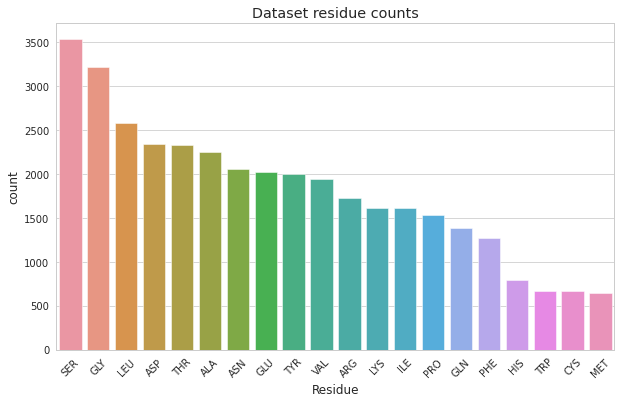

In [26]:
import seaborn as sns
plt.figure(figsize = (10,6))
df = pd.DataFrame(y_res_str)
df.rename(columns={0:'Residue'}, inplace=True)
sns.countplot(x='Residue', data = df, order = y_res_str.value_counts().index)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Dataset residue counts')
g ="Amino acid counts"
sns.set_style("whitegrid")
g